In [1]:
# Midbootcamp Project - Financial Risk Analyst - Logistic Regression

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from statsmodels.graphics.mosaicplot import mosaic

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.stats import chi2_contingency
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
%matplotlib inline

# Load Data

In [7]:
credit = pd.read_csv('../datasets/creditcardmarketing.csv')

In [8]:
credit

,1,No,Air Miles,Letter,High,1.1,No.1,High.1,2,1.2,4,No.2,1160.75,1669,877,1095,1002
0,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
1,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
2,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
3,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0
4,6,No,Air Miles,Letter,Medium,1,No,High,3,1,4,No,1114.75,1847.0,1365.0,750.0,497.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17994,17996,No,Cash Back,Letter,High,1,No,Low,1,1,5,Yes,167.50,136.0,65.0,71.0,398.0
17995,17997,No,Cash Back,Letter,High,1,No,Low,3,1,3,Yes,850.50,984.0,940.0,943.0,535.0
17996,17998,No,Cash Back,Letter,High,1,No,Low,2,1,4,No,1087.25,918.0,767.0,1170.0,1494.0
17997,17999,No,Cash Back,Letter,Medium,1,No,Medium,4,2,2,Yes,1022.25,626.0,983.0,865.0,1615.0


In [9]:
# check target variable

In [10]:
credit.No.value_counts()

No     16976
Yes     1023
Name: No, dtype: int64

## rename columns

In [11]:
columns_mapper = {'1':'customer', 
                  'No':'accept', 
                  'Air Miles':'reward', 
                  'Letter':'m_type', 
                  'High':'income', 
                  '1.1':'accounts', 
                  'No.1':'overdraft',
                  'High.1': 'rating', 
                  '2': 'cards', 
                  '1.2': 'homes', 
                  '4':'family', 
                  'No.2': 'owner', 
                  '1160.75':'q1',
                  '1669':'q2',
                  '877':'q3',
                  '1095':'q4',
                  '1002':'balance'}

In [12]:
# The balance seems to be the average balance for each quarter in the last year

In [13]:
credit = credit.rename(columns=columns_mapper)
credit.head()

,customer,accept,reward,m_type,income,accounts,overdraft,rating,cards,homes,family,owner,q1,q2,q3,q4,balance
0,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
1,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
2,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
3,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0
4,6,No,Air Miles,Letter,Medium,1,No,High,3,1,4,No,1114.75,1847.0,1365.0,750.0,497.0


In [14]:
# Save customer column

In [15]:
customer = credit.customer

In [16]:
credit = credit.iloc[:,1:]

In [17]:
credit.head()

,accept,reward,m_type,income,accounts,overdraft,rating,cards,homes,family,owner,q1,q2,q3,q4,balance
0,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
1,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
2,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
3,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0
4,No,Air Miles,Letter,Medium,1,No,High,3,1,4,No,1114.75,1847.0,1365.0,750.0,497.0


# EDA

In [18]:
# check data types

In [19]:
credit.dtypes

accept        object
reward        object
m_type        object
income        object
accounts       int64
overdraft     object
rating        object
cards          int64
homes          int64
family         int64
owner         object
q1           float64
q2           float64
q3           float64
q4           float64
balance      float64
dtype: object

In [20]:
# Appart from the balance columns all the other features could be considered categorical: nominal or ordinals

## General info

In [21]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17999 entries, 0 to 17998
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   accept     17999 non-null  object 
 1   reward     17999 non-null  object 
 2   m_type     17999 non-null  object 
 3   income     17999 non-null  object 
 4   accounts   17999 non-null  int64  
 5   overdraft  17999 non-null  object 
 6   rating     17999 non-null  object 
 7   cards      17999 non-null  int64  
 8   homes      17999 non-null  int64  
 9   family     17999 non-null  int64  
 10  owner      17999 non-null  object 
 11  q1         17975 non-null  float64
 12  q2         17975 non-null  float64
 13  q3         17975 non-null  float64
 14  q4         17975 non-null  float64
 15  balance    17975 non-null  float64
dtypes: float64(5), int64(4), object(7)
memory usage: 2.2+ MB


In [22]:
credit.describe()

,accounts,cards,homes,family,q1,q2,q3,q4,balance
count,17999.000000,17999.000000,17999.000000,17999.000000,17975.000000,17975.000000,17975.000000,17975.000000,17975.000000
mean,1.255792,1.903495,1.203456,3.499028,940.503310,910.408456,999.398999,1042.030654,810.175132
std,0.472510,0.797031,0.427350,1.114207,350.303729,620.068494,457.414081,553.467854,559.015084
min,1.000000,1.000000,1.000000,1.000000,48.250000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,3.000000,787.500000,392.500000,663.000000,633.000000,363.000000
50%,1.000000,2.000000,1.000000,3.000000,1007.000000,772.000000,1032.000000,945.000000,703.000000
75%,1.000000,2.000000,1.000000,4.000000,1153.125000,1521.000000,1342.000000,1463.000000,1212.000000
max,3.000000,4.000000,3.000000,9.000000,3366.250000,3450.000000,3421.000000,3823.000000,4215.000000


In [23]:
credit.describe(include=['object'])

,accept,reward,m_type,income,overdraft,rating,owner
count,17999,17999,17999,17999,17999,17999,17999
unique,2,3,2,3,2,3,2
top,No,Air Miles,Postcard,Medium,No,High,Yes
freq,16976,6060,9147,9013,15321,6070,11655


In [24]:
credit.isna().sum()

accept        0
reward        0
m_type        0
income        0
accounts      0
overdraft     0
rating        0
cards         0
homes         0
family        0
owner         0
q1           24
q2           24
q3           24
q4           24
balance      24
dtype: int64

## Explore single variables

In [25]:
for c in credit.columns:
    print(credit[c].nunique(), c)

2 accept
3 reward
2 m_type
3 income
3 accounts
2 overdraft
3 rating
4 cards
3 homes
8 family
2 owner
4728 q1
2158 q2
1945 q3
2281 q4
2184 balance


In [26]:
credit.family.value_counts()

3    5712
4    5542
5    2853
2    2813
1     539
6     538
8       1
9       1
Name: family, dtype: int64

In [27]:
#%writefile my_functions.py

#a = 100

#from my_functions import continuous_discrete

## Discrete variables

In [28]:
def continuous_discrete(df,n=10):
    """divides a data frame into continuous and discrete variables
    based on n, the number of classes."""
    cont = []
    disc = []
    for c in df.columns:
        if df[c].nunique() >= n:
            cont.append(c)
        else:
            disc.append(c)
    
    continuous_df = df[cont]
    discret_df = df[disc]
    
    return continuous_df, discret_df

In [29]:
conti, disc = continuous_discrete(credit,10)

In [30]:
def plotDiscrete(df):
    """Countplots for a dataframe of discrete variables"""
    for c in df.columns:
        ax = sns.countplot(x=c,data=df)
        plt.title(c)
        plt.xlabel(None)
        plt.tick_params(axis='x', labelrotation=55)
        # annotate
        ax.bar_label(ax.containers[0], label_type='edge')

        # pad the spacing between the number and the edge of the figure
        ax.margins(y=0.1)
        
        plt.show()

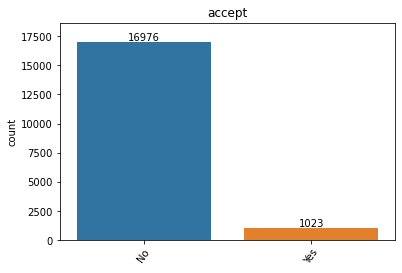

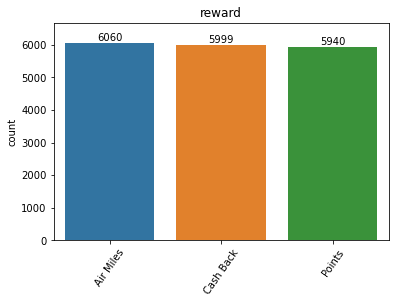

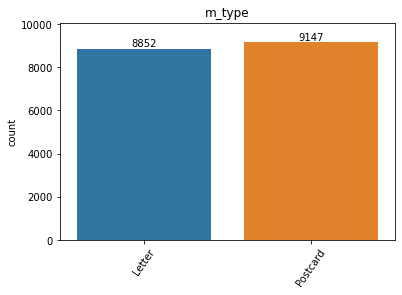

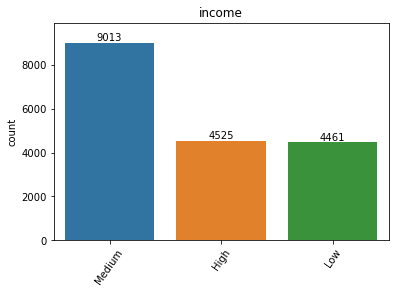

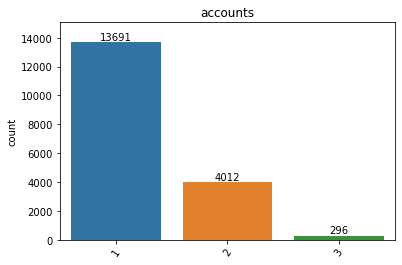

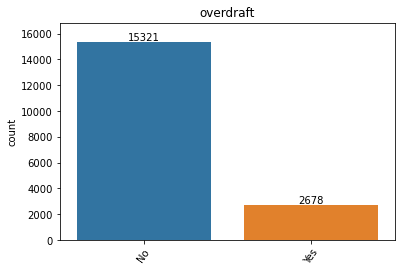

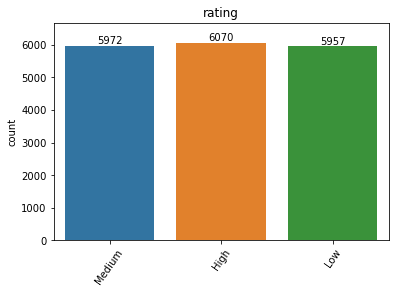

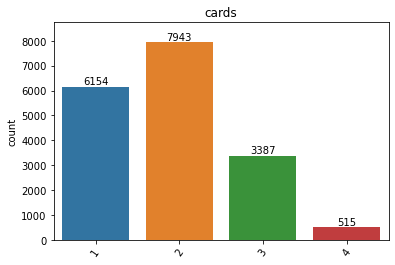

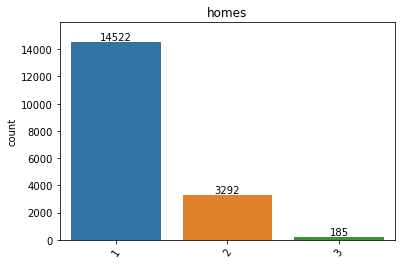

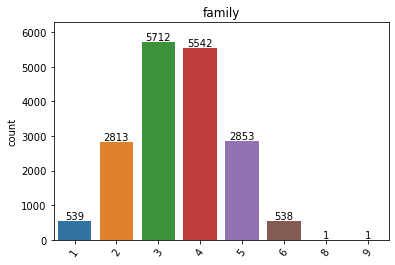

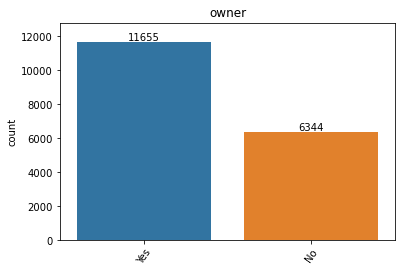

In [31]:
plotDiscrete(disc)

In [32]:
ordinals = ['family', 'homes', 'cards', 'rating', 'accounts', 'income']

In [33]:
nominals = []
for f in disc.columns:
    if f not in ordinals:
        nominals += [f]
nominals

['accept', 'reward', 'm_type', 'overdraft', 'owner']

## Continuous variables

### Histograms

In [34]:
def plotContinuous(df):
    """Histplots for a dataframe of continuous variables"""
    for c in df.columns:
        sns.histplot(x=c,data=df, kde=True)
        plt.title(c)
        plt.xlabel(None)
        plt.tick_params(axis='x', labelrotation=55)
        plt.show()

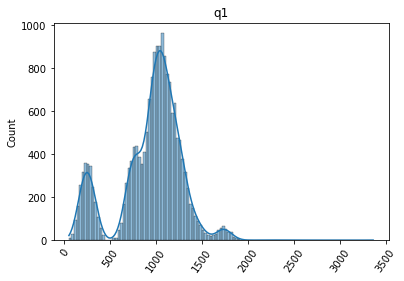

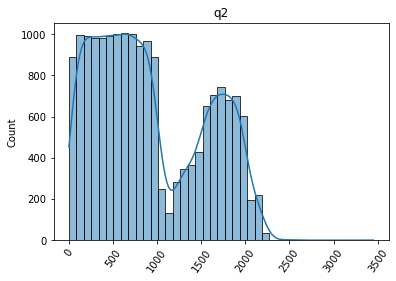

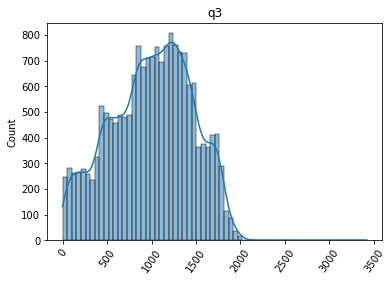

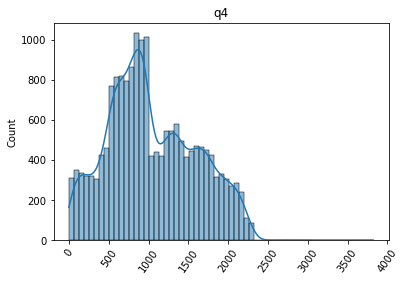

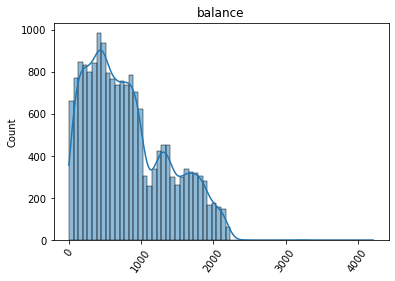

In [35]:
plotContinuous(conti)

In [36]:
conti.skew()

q1        -0.572253
q2         0.411053
q3        -0.183032
q4         0.289637
balance    0.641226
dtype: float64

__There is no relevant skewness__

In [37]:
conti.std()

q1         350.303729
q2         620.068494
q3         457.414081
q4         553.467854
balance    559.015084
dtype: float64

In [38]:
conti.mean()

q1          940.503310
q2          910.408456
q3          999.398999
q4         1042.030654
balance     810.175132
dtype: float64

### Outliers

In [39]:
def plotOutliers(df):
    """Boxplots for a dataframe of continuous variables"""
    for c in df.columns:
        sns.set_theme(style="whitegrid")
        ax = sns.boxplot(x=c, data=df, orient='h')
        plt.title(c)
        plt.xlabel(None)
        #plt.tick_params(axis='x', labelrotation=55)
        plt.show()

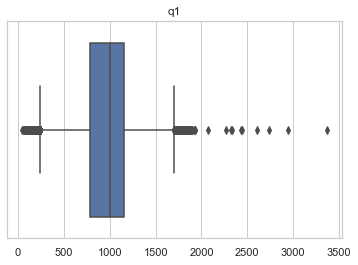

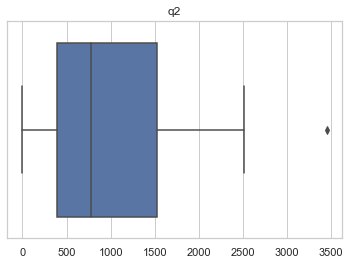

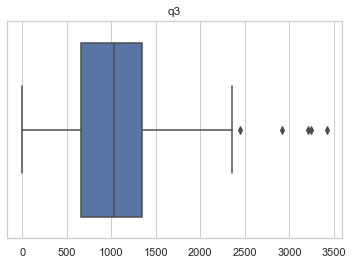

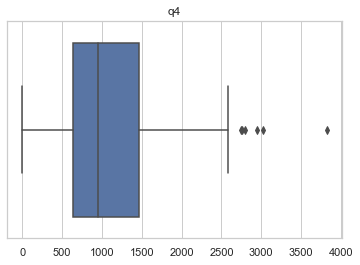

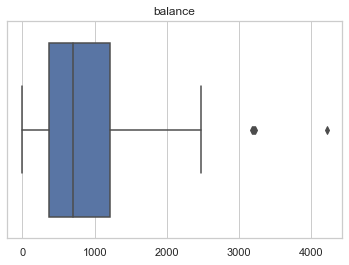

In [40]:
plotOutliers(conti)

There are some outliers.

### Correlations

In [41]:
def corrPlots(df):
    """ Plots correlation matrix, heatmap and pairplot"""
    display(df.corr())
    sns.heatmap(round(df.corr(),3), vmin = -1, vmax = 1, cmap = 'RdBu', annot=True)
    plt.show()
    sns.pairplot(df)
    plt.show()

,q1,q2,q3,q4,balance
q1,1.000000,0.481490,0.800305,0.752746,0.572376
q2,0.481490,1.000000,0.483173,-0.060970,-0.237317
q3,0.800305,0.483173,1.000000,0.487712,0.168961
q4,0.752746,-0.060970,0.487712,1.000000,0.565298
balance,0.572376,-0.237317,0.168961,0.565298,1.000000


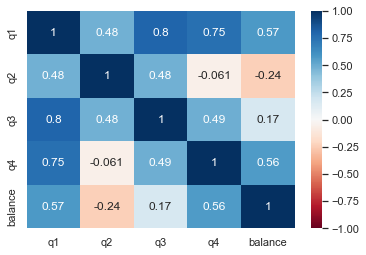

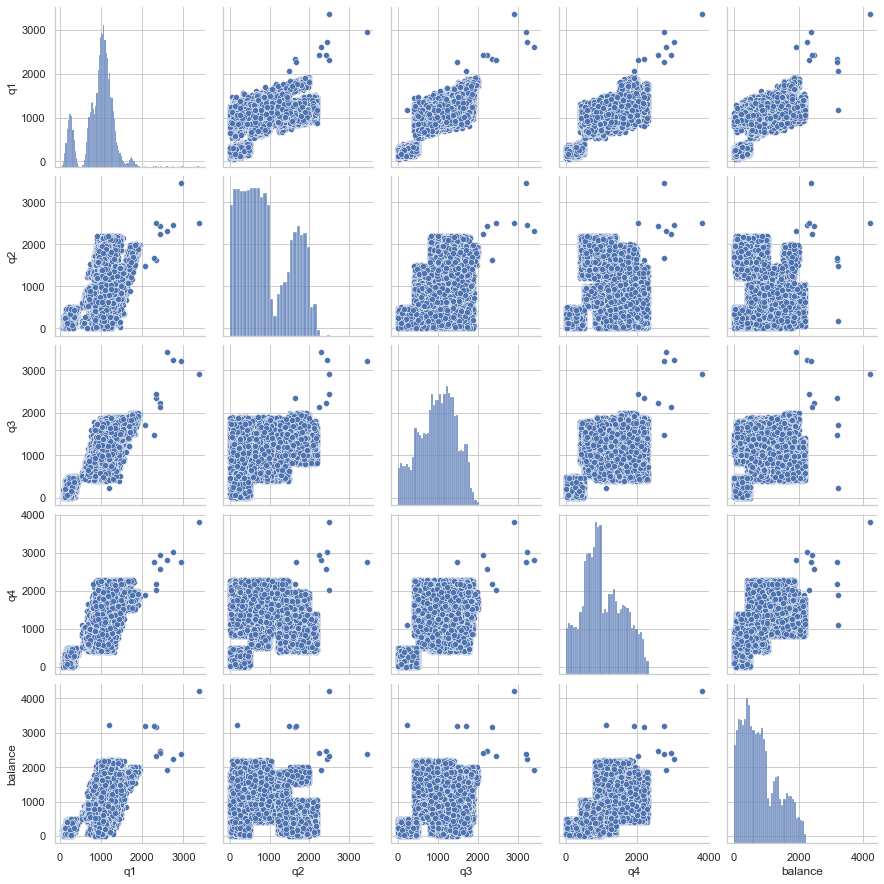

In [42]:
corrPlots(conti)

__There is multicollinearity!__  
q3 coulb be dropped

## Explore variables in pairs

In [43]:
# Compute class imbalance in accept

In [44]:
# Count acceptance
count_accept = disc.accept.value_counts()
count_accept

No     16976
Yes     1023
Name: accept, dtype: int64

In [45]:
# Percentage of acceptance
100*(count_accept/len(disc))

No     94.316351
Yes     5.683649
Name: accept, dtype: float64

In [46]:
print("The class imbalance ratio is: {:.2f}".format((count_accept[0]-count_accept[1])/(count_accept[0]+count_accept[1])))



The class imbalance ratio is: 0.89


### Filter accepted customers

In [47]:
disc_accepted = disc[disc.accept == 'Yes']

In [48]:
disc_rejected = disc[disc.accept == 'No']

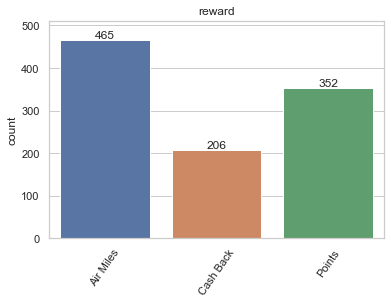

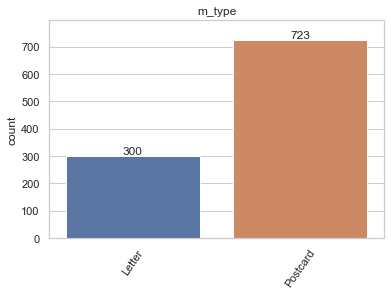

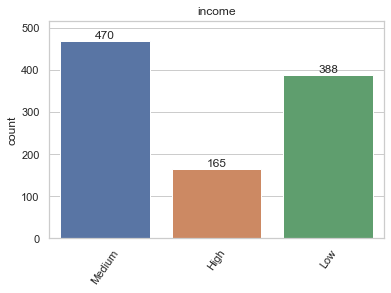

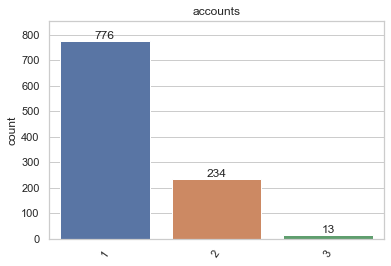

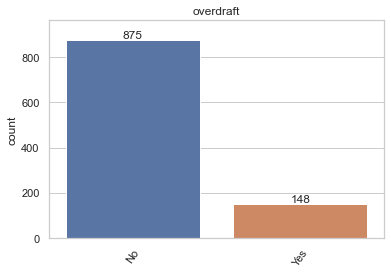

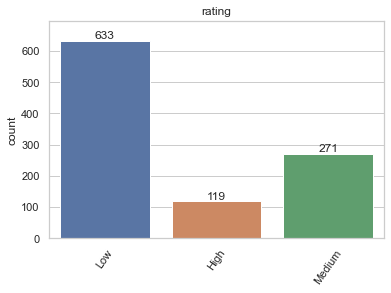

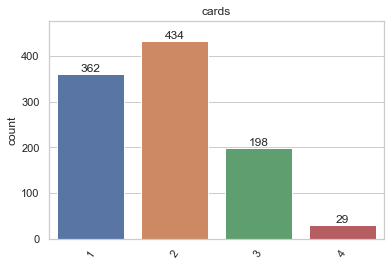

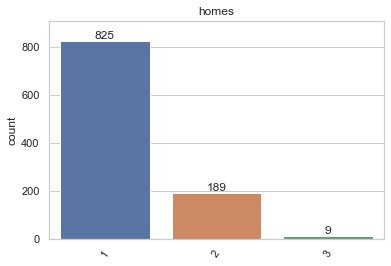

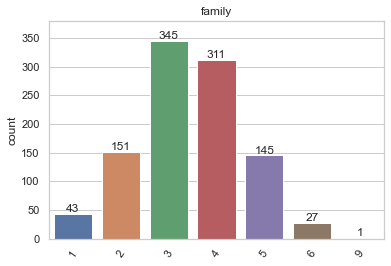

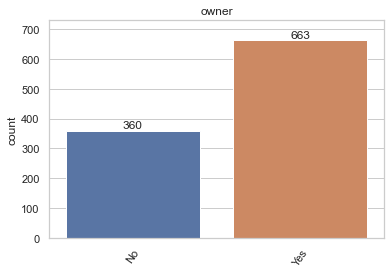

In [49]:
plotDiscrete(disc_accepted.iloc[:,1:])

### Plot discrete features against accepted.

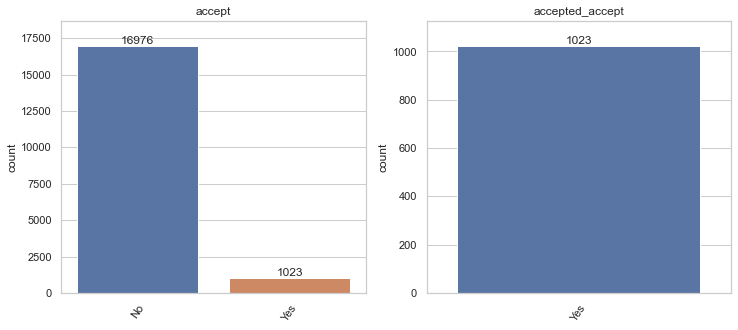

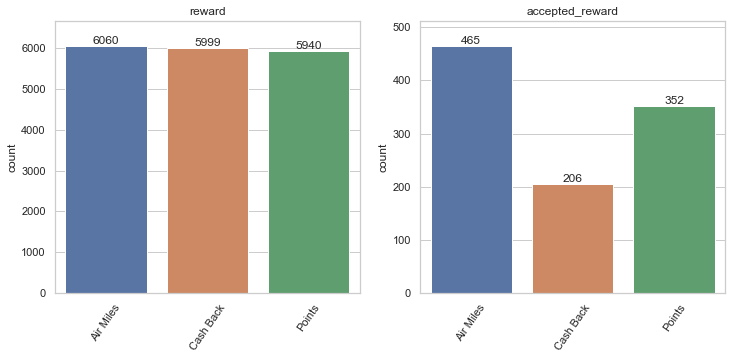

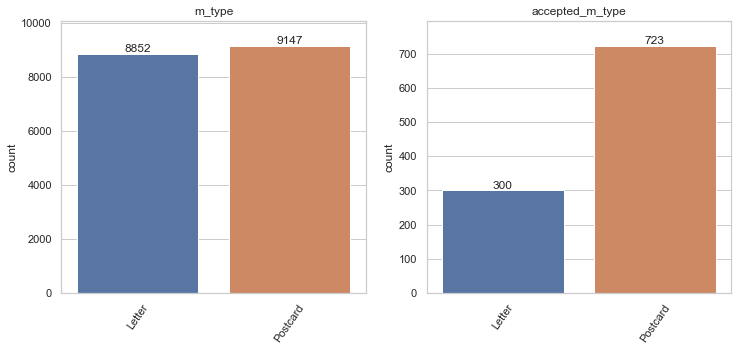

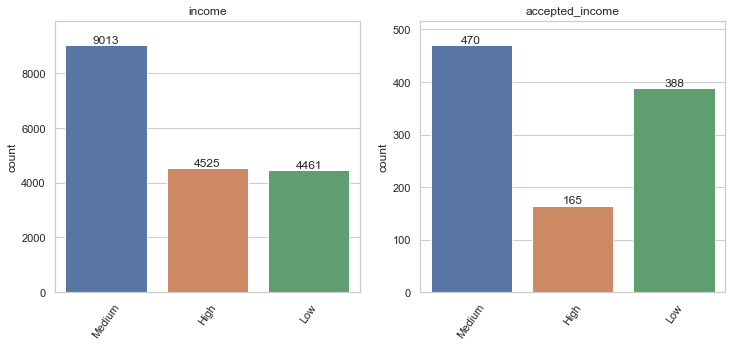

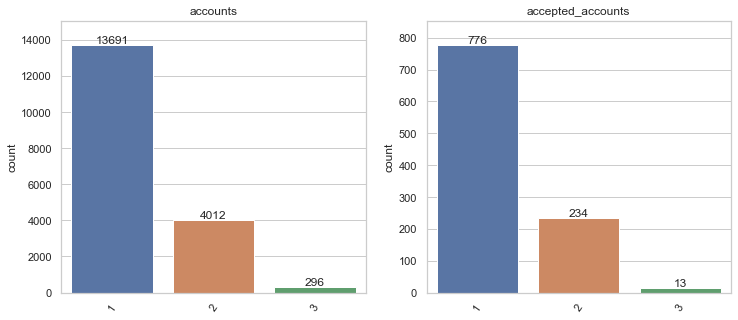

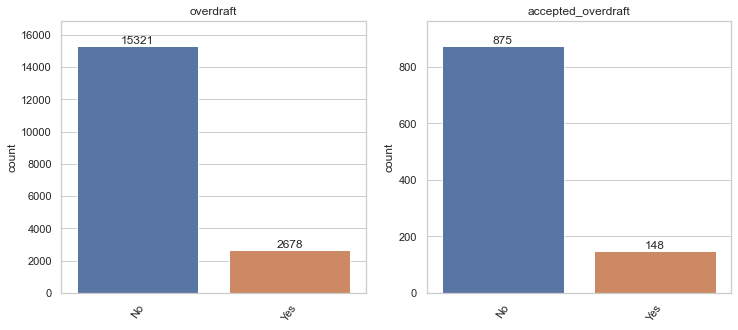

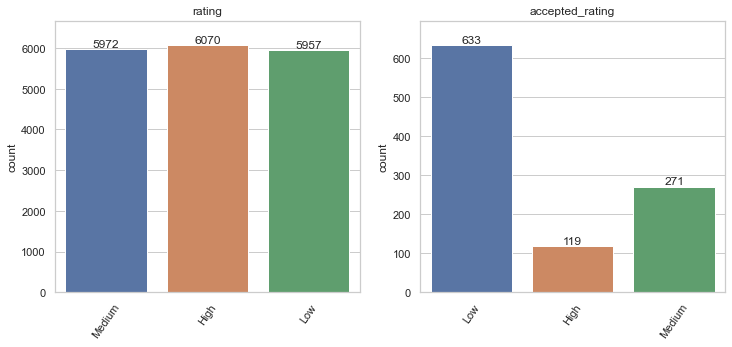

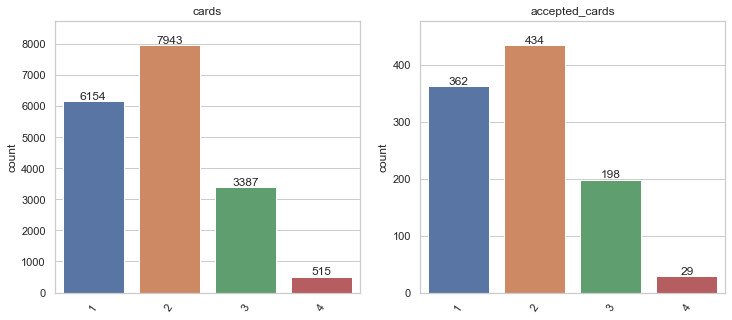

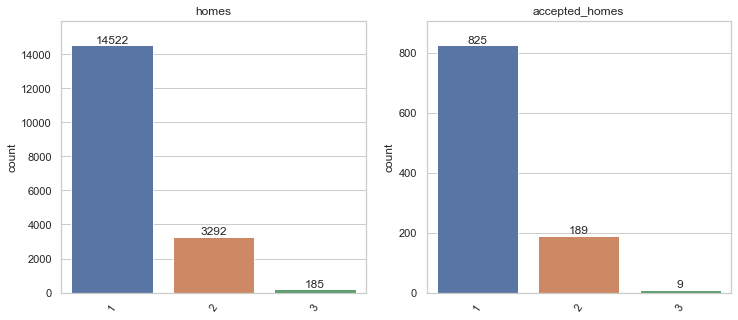

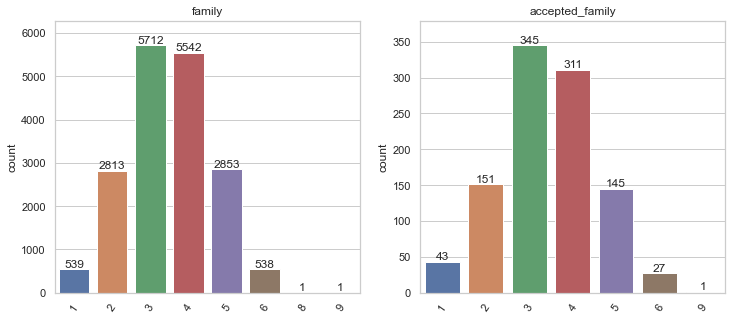

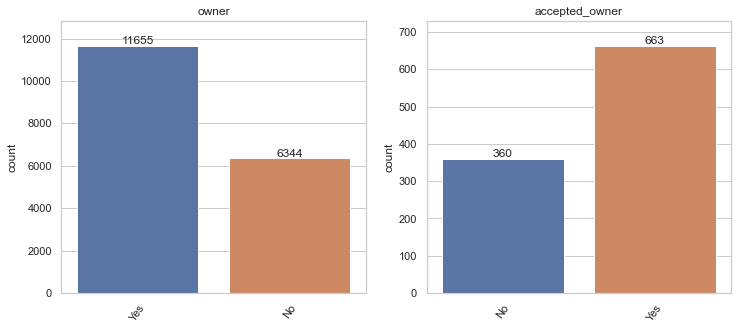

In [50]:

for i,c in enumerate(disc.columns):
    f, ax = plt.subplots(1,2, figsize=(12,5))
    #sns.countplot(x=c,data=disc_rejected,ax=ax[0])
    sns.countplot(x=c,data=disc, ax=ax[0])
    sns.countplot(x=c,data=disc_accepted,ax=ax[1])
    
    # plt.title(c)
    #ax[0].set_title('rejected_%s' %(c))
    #ax[0].set_xlabel(None)
    #ax[0].tick_params(axis='x', labelrotation=55)
    
    ax[0].set_title(c)
    ax[0].set_xlabel(None)
    ax[0].tick_params(axis='x', labelrotation=55)
    
    ax[1].set_title('accepted_%s' %(c))
    ax[1].set_xlabel(None)
    ax[1].tick_params(axis='x', labelrotation=55)
    
        # annotate
    #ax[0].bar_label(ax[0].containers[0], label_type='edge')
    ax[0].bar_label(ax[0].containers[0], label_type='edge')
    ax[1].bar_label(ax[1].containers[0], label_type='edge')

        # pad the spacing between the number and the edge of the figure
    #ax[0].margins(y=0.1)
    ax[0].margins(y=0.1)
    ax[1].margins(y=0.1)
    
    
    plt.show()
        


There is a significant preference to Air Miles and Postcards.  
Also low (and medium) income and (low and medium) rating accept easier.  
  
In the other hand, the variables which maintain a similar relationship will be good to predict the results. For instance: overdraft and owner.   
  
What does the class imbalance has to do here?

In [51]:
# function compare discrete distributions

In [52]:
def plotCompareDiscrete(disc, sub_disc):
    """Compare the distributions of classes of two dataframes with the same discrete variables"""
    
    for i,c in enumerate(disc.columns):
        f, ax = plt.subplots(1,2, figsize=(12,5))
        sns.countplot(x=c,data=disc, ax=ax[0])
        sns.countplot(x=c,data=sub_disc,ax=ax[1])


        ax[0].set_title('original_%s' %(c))
        ax[0].set_xlabel(None)
        ax[0].tick_params(axis='x', labelrotation=55)

        ax[1].set_title('compared_%s' %(c))
        ax[1].set_xlabel(None)
        ax[1].tick_params(axis='x', labelrotation=55)

            # annotate
        ax[0].bar_label(ax[0].containers[0], label_type='edge')
        ax[1].bar_label(ax[1].containers[0], label_type='edge')

            # pad the spacing between the number and the edge of the figure
        ax[0].margins(y=0.1)
        ax[1].margins(y=0.1)


        plt.show()


### Violin plot continuous

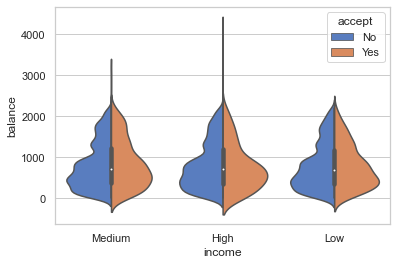

In [53]:
sns.violinplot(y='balance', x= 'income', hue='accept', data = credit, scale = "area", split=True, palette='muted', aplha =.2);
# plt.show()
# It does not work

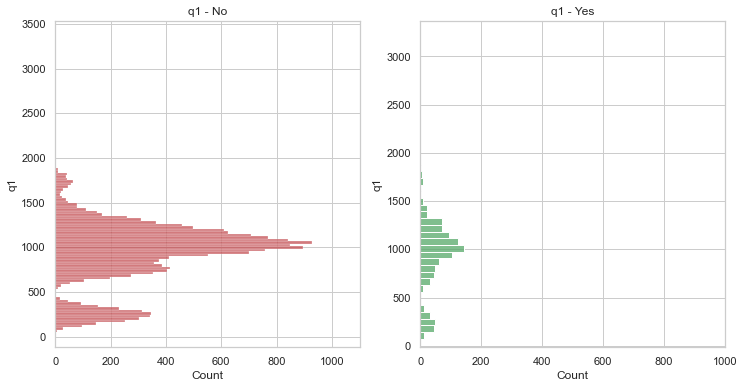

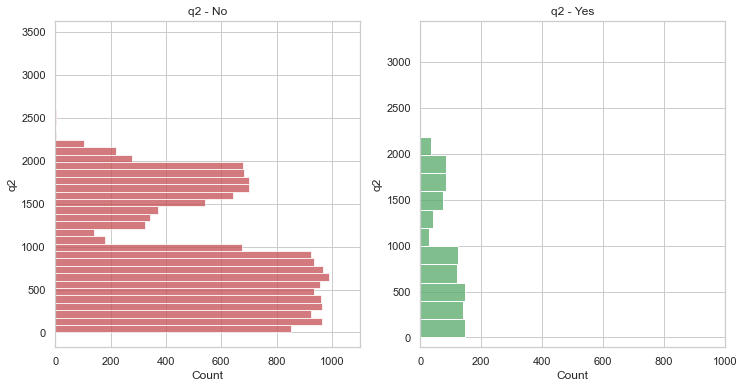

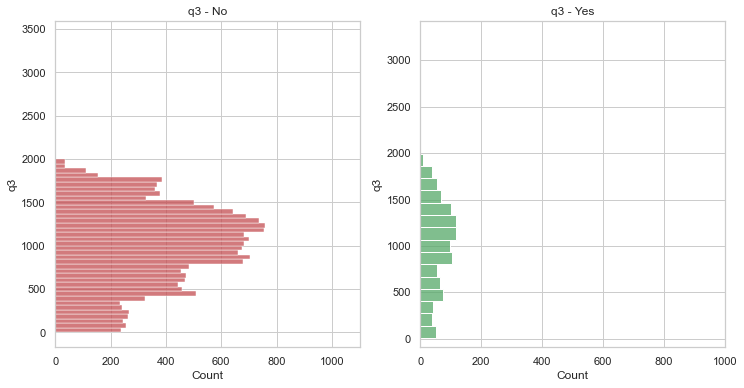

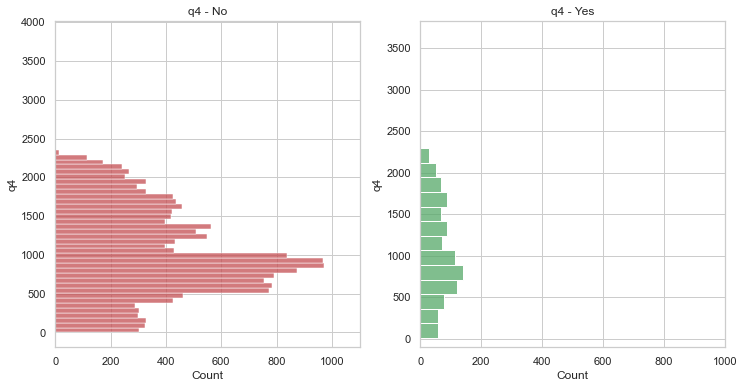

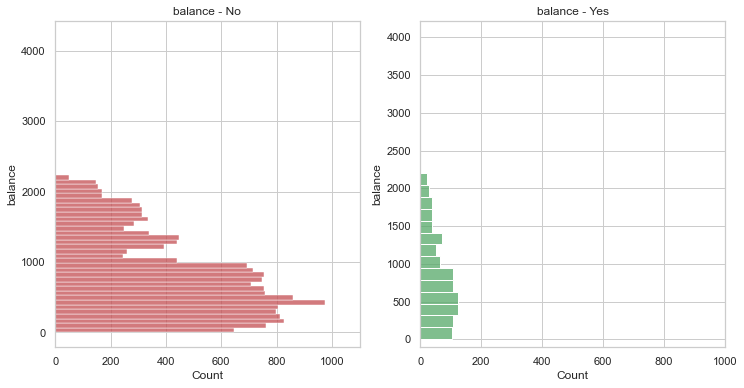

In [54]:
for f in conti.columns:
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    sns.histplot(y=credit[f][credit.accept == 'No'], ax=ax[0], color ='r')
    sns.histplot(y=credit[f][credit.accept == 'Yes'], ax=ax[1], color='g')
    ax[0].set_title('%s - No'%(f))
    ax[0].set_xlim(0,1100)
    ax[1].set_ylim(ymax=max(credit[f][credit.accept == 'No']))
    ax[1].set_title('%s - Yes'%(f))
    ax[1].set_xlim(0,1000)
    plt.show()

# Data Cleaning

## Ordinals mappers

In [55]:
ordinals

['family', 'homes', 'cards', 'rating', 'accounts', 'income']

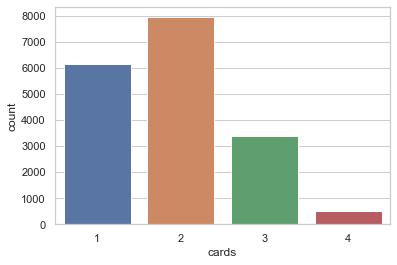

In [56]:
sns.countplot(x = disc.cards)
plt.show()

In [57]:
credit.rating.value_counts()

High      6070
Medium    5972
Low       5957
Name: rating, dtype: int64

In [58]:
family_mapper = {1:1,2:2,3:3,4:4,5:5,6:5,8:5,9:5}

In [59]:
homes_mapper = {1:1,2:2,3:2}

In [60]:
cards_mapper = {1:1,2:2,3:3,4:3}

In [61]:
rating_mapper = {'Low':1,'Medium':2,'High':3}

In [62]:
account_mapper = {1:1,2:2,3:2}

In [63]:
income_mapper = {'Low':1,'Medium':2,'High':3}

In [64]:
mappers = {}
mappers['family'] = family_mapper
mappers['homes'] = homes_mapper
mappers['cards'] = cards_mapper
mappers['rating'] = rating_mapper
mappers['accounts'] = account_mapper
mappers['income'] = income_mapper

## Treat NaN

In [65]:
100*credit.isna().sum()/len(credit)

accept       0.000000
reward       0.000000
m_type       0.000000
income       0.000000
accounts     0.000000
overdraft    0.000000
rating       0.000000
cards        0.000000
homes        0.000000
family       0.000000
owner        0.000000
q1           0.133341
q2           0.133341
q3           0.133341
q4           0.133341
balance      0.133341
dtype: float64

In [66]:
credit[credit.balance.isna()]

,accept,reward,m_type,income,accounts,overdraft,rating,cards,homes,family,owner,q1,q2,q3,q4,balance
322,No,Points,Postcard,Medium,1,No,High,1,1,4,No,NaN,NaN,NaN,NaN,NaN
3069,Yes,Air Miles,Postcard,Low,3,No,Medium,2,1,4,Yes,NaN,NaN,NaN,NaN,NaN
3107,No,Air Miles,Letter,Low,1,No,High,3,1,4,Yes,NaN,NaN,NaN,NaN,NaN
3788,No,Air Miles,Letter,Medium,2,No,High,3,1,3,No,NaN,NaN,NaN,NaN,NaN
5082,No,Points,Letter,Medium,1,No,High,1,1,3,Yes,NaN,NaN,NaN,NaN,NaN
5676,No,Air Miles,Postcard,Low,1,No,Low,2,1,4,Yes,NaN,NaN,NaN,NaN,NaN
5688,No,Air Miles,Postcard,Medium,1,No,Medium,3,1,5,No,NaN,NaN,NaN,NaN,NaN
6931,No,Air Miles,Postcard,Medium,1,No,Medium,2,2,4,Yes,NaN,NaN,NaN,NaN,NaN
7786,No,Air Miles,Letter,Low,2,No,Low,1,1,4,Yes,NaN,NaN,NaN,NaN,NaN
7863,No,Cash Back,Postcard,High,2,Yes,Low,2,1,3,No,NaN,NaN,NaN,NaN,NaN


In [67]:
100*(credit.accept[credit.balance.isna()].value_counts())/len(credit[credit.balance.isna()])

No     91.666667
Yes     8.333333
Name: accept, dtype: float64

If only there were no Yes in accept.  
Anyway, the amount is really small.  
I am dropping them

In [68]:
credit.accept[credit.balance.isna()].value_counts()

No     22
Yes     2
Name: accept, dtype: int64

In [69]:
credit.dropna(inplace=True)

In [70]:
credit.shape

(17975, 16)

### Drop them in the other data frames

In [71]:
conti.dropna(inplace=True)

/Users/albertomengual/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [72]:
conti.shape

(17975, 5)

In [73]:
disc = disc.iloc[credit.index,:]
disc.shape

(17975, 11)

## Remove outliers

### Count Outliers

In [104]:
def countOutliers(df):
    """Counts the outliers in every column of a continuous data frame.
    Returns a data frame with the information of the outliers including its actual sub-dataframes.
    It is just done for the UPPER limit. Not yet for the lower"""
    
    out_data = {'feature':[], 'iqr':[], 'upper':[], 'n_outliers':[], 'outliers_df':[] } #'lower':[], 
    
    for c in df.columns:
        iqr = np.nanpercentile(df[c] ,75) - np.nanpercentile(df[c],25)
        
        upper_limit = np.nanpercentile(df[c],75) + 1.5*iqr
        if upper_limit < df[c].max():
            out_data['feature'].append(c)
            out_data['iqr'].append(iqr)
            out_data['upper'].append(upper_limit)
            
            outliers = df[df[c] > upper_limit]
            out_data['outliers_df'].append(outliers)
            out_data['n_outliers'].append(len(outliers))
            
            print('The variable {} has {} outliers.'.format(c,len(outliers)))
        
        else:
            # out_data['upper'].append(df[c].max())
            print('The variable {} does not have upper outliers.'.format(c))
    out_data = pd.DataFrame(out_data)
    
    return out_data


In [447]:
outliers_data = countOutliers(conti)

The variable q1 has 278 outliers.
The variable q2 has 1 outliers.
The variable q3 has 5 outliers.
The variable q4 has 6 outliers.
The variable balance has 5 outliers.


In [448]:
outliers_data

,feature,iqr,upper,n_outliers,outliers_df
0,q1,365.625,1701.5625,278,q1 q2 q3 q4 balanc...
1,q2,1128.500,3213.7500,1,q1 q2 q3 q4 balance...
2,q3,679.000,2360.5000,5,q1 q2 q3 q4 balanc...
3,q4,830.000,2708.0000,6,q1 q2 q3 q4 balanc...
4,balance,849.000,2485.5000,5,q1 q2 q3 q4 balanc...


### Treat outliers

#### q1

In [449]:
q1_outliers = outliers_data.loc[0,'outliers_df']

In [450]:
q1_outliers.head()

,q1,q2,q3,q4,balance
21,1754.00,1876.0,1717.0,1507.0,1916.0
78,1735.50,1610.0,1746.0,1972.0,1614.0
97,1791.25,1790.0,1994.0,1616.0,1765.0
133,1791.75,1735.0,1950.0,1500.0,1982.0
148,1809.00,1968.0,1762.0,1534.0,1972.0


In [451]:
credit.accept[q1_outliers.index].value_counts()

No     264
Yes     14
Name: accept, dtype: int64

As some of the outliers in q1 have the value Yes in accept I will not remove them but equal them to the upper limit.

In [452]:
q1_upper = outliers_data.loc[0,'upper']
q1_upper

1701.5625

In [453]:
conti.q1[q1_outliers.index] = q1_upper

/Users/albertomengual/opt/anaconda3/lib/python3.9/site-packages/pandas/core/series.py:1135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_values(indexer, value)
/var/folders/wh/b1t7_x71343d359xkfyw5n2m0000gn/T/ipykernel_15660/881233036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conti.q1[q1_outliers.index] = q1_upper


In [454]:
# Also in credit

In [455]:
credit.q1[q1_outliers.index] = q1_upper

/var/folders/wh/b1t7_x71343d359xkfyw5n2m0000gn/T/ipykernel_15660/3948003616.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit.q1[q1_outliers.index] = q1_upper


#### q2

In [456]:
q2_outliers = outliers_data.loc[1,'outliers_df']

In [457]:
credit.accept[q2_outliers.index]

12634    No
Name: accept, dtype: object

This one I can just drop it.

In [458]:
conti.drop(index=q2_outliers.index, inplace=True)

/Users/albertomengual/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [459]:
credit.drop(index=q2_outliers.index, inplace=True)

In [460]:
credit.shape

(17974, 16)

#### q3

In [461]:
# There were common outliers, recount

In [462]:
outliers_data2 = countOutliers(conti)

The variable q1 has 277 outliers.
The variable q2 does not have upper outliers.
The variable q3 has 4 outliers.
The variable q4 has 5 outliers.
The variable balance has 5 outliers.


In [463]:
outliers_data2

,feature,iqr,upper,n_outliers,outliers_df
0,q1,365.5,1701.25,277,q1 q2 q3 q4 bala...
1,q3,679.0,2360.50,4,q1 q2 q3 q4 bala...
2,q4,830.0,2708.00,5,q1 q2 q3 q4 bala...
3,balance,849.0,2485.50,5,q1 q2 q3 q4 bala...


In [464]:
q3_outliers = outliers_data2.loc[1,'outliers_df']

In [465]:
credit.accept[q3_outliers.index]

2295     No
8886     No
10575    No
15258    No
Name: accept, dtype: object

I will drop them too.

In [466]:
credit.drop(index=q3_outliers.index, inplace=True)

In [467]:
conti.drop(index=q3_outliers.index, inplace=True)

/Users/albertomengual/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### q4

In [468]:
outliers_data2 = countOutliers(conti)

The variable q1 has 274 outliers.
The variable q2 does not have upper outliers.
The variable q3 does not have upper outliers.
The variable q4 has 2 outliers.
The variable balance has 4 outliers.


In [469]:
outliers_data2

,feature,iqr,upper,n_outliers,outliers_df
0,q1,365.25,1700.625,274,q1 q2 q3 q4 bala...
1,q4,829.00,2705.500,2,q1 q2 q3 q4 bala...
2,balance,848.75,2484.875,4,q1 q2 q3 q4 bala...


#### balance

In [470]:
balance_outliers = outliers_data2.loc[2,'outliers_df']

In [471]:
credit.accept[balance_outliers.index]

2654     No
8776     No
12632    No
15607    No
Name: accept, dtype: object

I will drop them too.

In [472]:
credit.drop(index=balance_outliers.index, inplace = True)

In [473]:
conti.drop(index=balance_outliers.index, inplace = True)

/Users/albertomengual/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [474]:
outliers_data2=countOutliers(conti)

The variable q1 has 273 outliers.
The variable q2 does not have upper outliers.
The variable q3 does not have upper outliers.
The variable q4 has 1 outliers.
The variable balance does not have upper outliers.


In [475]:
outliers_data2

,feature,iqr,upper,n_outliers,outliers_df
0,q1,365.0,1700.0,273,q1 q2 q3 q4 bala...
1,q4,829.0,2705.5,1,q1 q2 q3 q4 bala...


In [476]:
q4_outliers = outliers_data2.loc[1,'outliers_df']

In [477]:
credit.accept[q4_outliers.index]

14002    No
Name: accept, dtype: object

I am dropping it too...

In [478]:
credit.drop(index=q4_outliers.index, inplace=True)

In [479]:
conti.drop(index=q4_outliers.index, inplace=True)

/Users/albertomengual/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [480]:
# I have been working over credit and conti. disc has still more rows.

In [481]:
print(credit.shape)
print(conti.shape)
print(disc.shape)

(17965, 16)
(17965, 5)
(17975, 11)


# Data Preprocessing

# Check linear model in conti

In [482]:
# Split X-y

In [77]:
conti.head()

,q1,q2,q3,q4,balance
0,147.25,39.0,106.0,78.0,366.0
1,276.50,367.0,352.0,145.0,242.0
2,1219.00,1578.0,1760.0,1119.0,419.0
3,1211.00,2140.0,1357.0,982.0,365.0
4,1114.75,1847.0,1365.0,750.0,497.0


In [78]:
y_conti = conti.balance
X_conti = conti.iloc[:,:-1]

In [79]:
lm_conti = LinearRegression().fit(X_conti,y_conti)

In [80]:
lm_conti.score(X_conti,y_conti)

1.0

In [81]:
lm_conti.coef_

array([ 4., -1., -1., -1.])

In [82]:
lm_conti.intercept_

-1.1368683772161603e-12

As I understand balance contains all the information in the other qn variables.

I can just keep balance and drop q1, q2, q3, q4. Or keep q's and drop balance.

# Prepare dataframes for preprocessing

In [489]:
# Create a copy of credit

In [83]:
df = credit.copy()

In [84]:
df.shape

(17975, 16)

In [85]:
credit.isna().sum()

accept       0
reward       0
m_type       0
income       0
accounts     0
overdraft    0
rating       0
cards        0
homes        0
family       0
owner        0
q1           0
q2           0
q3           0
q4           0
balance      0
dtype: int64

In [86]:
df.isna().sum()

accept       0
reward       0
m_type       0
income       0
accounts     0
overdraft    0
rating       0
cards        0
homes        0
family       0
owner        0
q1           0
q2           0
q3           0
q4           0
balance      0
dtype: int64

In [494]:
# Check previous split

In [87]:
disc.dtypes

accept       object
reward       object
m_type       object
income       object
accounts      int64
overdraft    object
rating       object
cards         int64
homes         int64
family        int64
owner        object
dtype: object

In [88]:
conti.dtypes

q1         float64
q2         float64
q3         float64
q4         float64
balance    float64
dtype: object

In [89]:
def defOrdinals(df_cat, mappers_dic):
    """Defines as Categoricals Ordered all the features inside a mapper dictionary of mappers 
    returns a dataframe with the ordinal features transformed"""
    for feat in mappers_dic.keys():
        df_cat[feat] = df_cat[feat].map(mappers_dic[feat])
        df_cat[feat] = pd.Categorical(df_cat[feat], ordered = True)
    
    return df_cat

In [ ]:
# Remember

In [90]:
# df = defOrdinals(df, mappers)
df.head()

,accept,reward,m_type,income,accounts,overdraft,rating,cards,homes,family,owner,q1,q2,q3,q4,balance
0,No,Air Miles,Letter,2,1,No,2,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
1,No,Air Miles,Postcard,3,2,No,2,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
2,No,Air Miles,Letter,2,2,No,3,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
3,No,Air Miles,Letter,2,1,No,2,2,1,5,Yes,1211.00,2140.0,1357.0,982.0,365.0
4,No,Air Miles,Letter,2,1,No,3,3,1,4,No,1114.75,1847.0,1365.0,750.0,497.0


In [499]:
# Drop q1, q2, q3, q4

In [91]:
df.drop(columns=['q1','q2','q3','q4'], inplace=True)
df.head()

,accept,reward,m_type,income,accounts,overdraft,rating,cards,homes,family,owner,balance
0,No,Air Miles,Letter,2,1,No,2,2,2,5,Yes,366.0
1,No,Air Miles,Postcard,3,2,No,2,2,1,2,Yes,242.0
2,No,Air Miles,Letter,2,2,No,3,1,1,4,No,419.0
3,No,Air Miles,Letter,2,1,No,2,2,1,5,Yes,365.0
4,No,Air Miles,Letter,2,1,No,3,3,1,4,No,497.0


In [92]:
df.dtypes

accept         object
reward         object
m_type         object
income       category
accounts     category
overdraft      object
rating       category
cards        category
homes        category
family       category
owner          object
balance       float64
dtype: object

## Split numerical and categorical

In [93]:
def numericCategorical(df):
    """Split a dataframe into numeric or categorical according to the data types
    (If it is passaed after continuousDiscrete all numeric should be CONTINUOUS)"""
    
    df_numeric = df._get_numeric_data()
    df_categorical = df.select_dtypes(include=['object','category'])
    
    return df_numeric, df_categorical


In [94]:
numeric, categorical = numericCategorical(df)

In [95]:
numeric.shape

(17975, 1)

In [96]:
categorical.shape

(17975, 11)

In [506]:
# Save df as credit clean

In [507]:
#df.to_csv('../datasets/credit_clean.csv')

# try feature selection over clean df

In [508]:
# nominal and ordinal

In [97]:
# Split nominal and ordinal out of a list
nominal_df = pd.DataFrame(index=df.index)
ordinal_df = pd.DataFrame(index= df.index)
for n in nominals:
    nominal_df[n] = categorical[n]
for o in ordinals:
    ordinal_df[o] = categorical[o]
display(nominal_df.tail())
ordinal_df.tail()

,accept,reward,m_type,overdraft,owner
17994,No,Cash Back,Letter,No,Yes
17995,No,Cash Back,Letter,No,Yes
17996,No,Cash Back,Letter,No,No
17997,No,Cash Back,Letter,No,Yes
17998,No,Cash Back,Letter,No,No


,family,homes,cards,rating,accounts,income
17994,5,1,1,1,1,3
17995,3,1,3,1,1,3
17996,4,1,2,1,1,3
17997,2,2,3,2,1,2
17998,3,1,2,2,2,1


## Chi-Square Test of Independence

Chi-Square Test of Independence.  
__Null Hypothesis H0:__ There is no relationship between the variables  
__Alternative Hypothesis H1:__ There is a relationship between variables

If the p-value is significant (in the rejection area) we can reject the null hypothesis. The two variables are related, non independent.

In [ ]:
alpha = 0.05

In [ ]:
chi_res = chi2_contingency(pd.crosstab(nominal_df.accept, nominal_df.accept))
chi_res

In [ ]:
print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

In [ ]:
chi2_data = {'nominal':[],'test_result':[], 'significance':[]}
related_categories = []

for c in nominal_df.iloc[:,1:].columns:
    p_value = chi2_contingency(pd.crosstab(nominal_df['accept'], nominal_df[c]))[1]

    chi2_data['nominal'].append(c)
    chi2_data['significance'].append(p_value)
    
    if p_value <= 0.05:        
        chi2_data['test_result'].append('Reject Null Hypothesis')
    
    else:
        chi2_data['test_result'].append('Fail to Reject Null Hypothesis')
        related_categories.append(c)

chi2_data = pd.DataFrame(chi2_data)

print(related_categories)
chi2_data

It is interesting that the related variables does not provide relevant information for the yes.  
Let's try and fix the class imbalance.

## chi2 function

In [ ]:
def independencyTest(df,target,alpha=0.05):
    """Checks if the nominal categorical variables are related or not to the target (dependent) variable.
    Inputs:
        df - nominal variables dataframe (the target is the first column)
        target - dependent variable
    Outputs:
        chi2_data - dataframe with the results of the chi2 test
        related_categories - a list of the categories related to the target"""
    
    chi2_data = {'nominal':[],'test_result':[], 'significance':[], 'chi2_st':[]}
    related_categories = []

    for c in df.iloc[:,1:].columns:
        p_value = chi2_contingency(pd.crosstab(df[target], df[c]))[1]
        chi2 = chi2_contingency(pd.crosstab(df[target], df[c]))[0]

        chi2_data['nominal'].append(c)
        chi2_data['significance'].append(p_value)
        chi2_data['chi2_st'].append(chi2)

        if p_value <= 0.05:        
            chi2_data['test_result'].append('Reject Null Hypothesis')

        else:
            chi2_data['test_result'].append('Fail to Reject Null Hypothesis')
            related_categories.append(c)

    chi2_data = pd.DataFrame(chi2_data)
    
    return related_categories, chi2_data
    

# Split X - y

In [98]:
df.head()

,accept,reward,m_type,income,accounts,overdraft,rating,cards,homes,family,owner,balance
0,No,Air Miles,Letter,2,1,No,2,2,2,5,Yes,366.0
1,No,Air Miles,Postcard,3,2,No,2,2,1,2,Yes,242.0
2,No,Air Miles,Letter,2,2,No,3,1,1,4,No,419.0
3,No,Air Miles,Letter,2,1,No,2,2,1,5,Yes,365.0
4,No,Air Miles,Letter,2,1,No,3,3,1,4,No,497.0


In [99]:
y = df.accept

In [100]:
X = df.iloc[:,1:]
X.head()

,reward,m_type,income,accounts,overdraft,rating,cards,homes,family,owner,balance
0,Air Miles,Letter,2,1,No,2,2,2,5,Yes,366.0
1,Air Miles,Postcard,3,2,No,2,2,1,2,Yes,242.0
2,Air Miles,Letter,2,2,No,3,1,1,4,No,419.0
3,Air Miles,Letter,2,1,No,2,2,1,5,Yes,365.0
4,Air Miles,Letter,2,1,No,3,3,1,4,No,497.0


## Train - test split

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 0)

# Remove outliers from train

In [ ]:
# I am doing it in the function ??

In [102]:
X_train.head()

,reward,m_type,income,accounts,overdraft,rating,cards,homes,family,owner,balance
7175,Air Miles,Postcard,1,1,No,2,1,1,4,Yes,1282.0
6165,Cash Back,Postcard,1,1,No,3,1,1,4,No,1221.0
11252,Points,Postcard,2,1,No,1,2,1,5,No,327.0
11893,Cash Back,Postcard,2,2,No,2,2,1,4,Yes,1454.0
13645,Points,Letter,2,1,No,1,2,1,3,Yes,435.0


In [105]:
out_data = countOutliers(X_train[['balance']])
out_data

The variable balance has 2 outliers.


,feature,iqr,upper,n_outliers,outliers_df
0,balance,847.0,2477.5,2,balance 8776 3201.0 2654 3178.0


In [106]:
# Get the indices of the outliers
indices = pd.Index([])
for i in out_data.index:
    indices = indices.append(out_data.loc[i,'outliers_df'].index)
indices = indices.drop_duplicates()

# Drop the outliers
X_train.drop(index=indices, inplace=True)
y_train.drop(index=indices, inplace=True)

In [107]:
X_train.shape

(13479, 11)

In [108]:
y_train.shape

(13479,)

In [109]:
X_test.shape

(4494, 11)

In [110]:
y_test.shape

(4494,)

# Random Undersampling

In [ ]:
# Try random undersampler

In [111]:
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train,y_train)

In [112]:
X_train_rus.shape

(1510, 11)

In [113]:
y_train_rus.shape

(1510,)

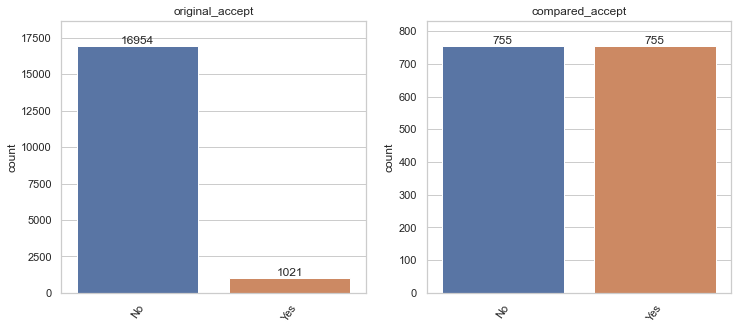

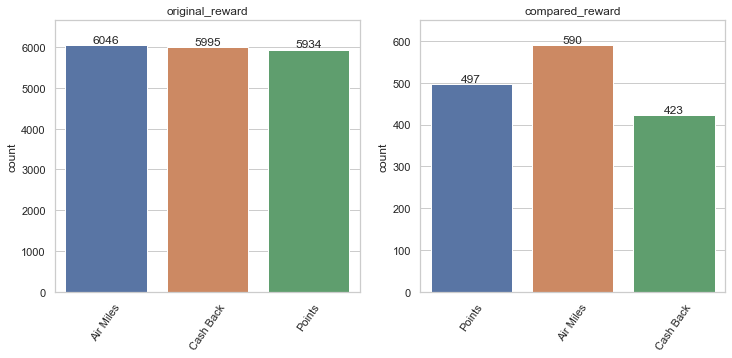

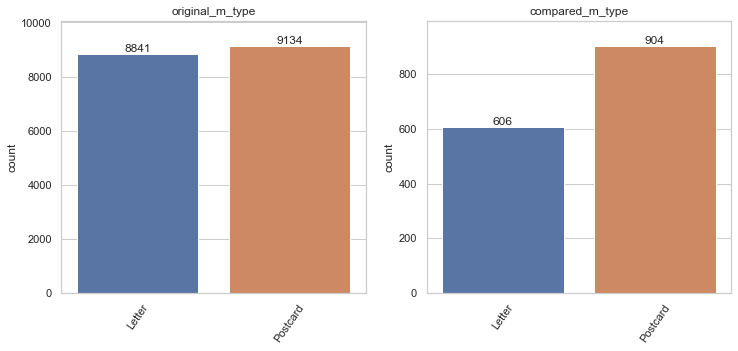

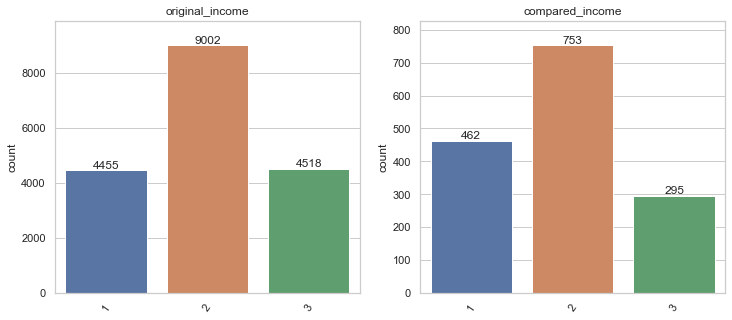

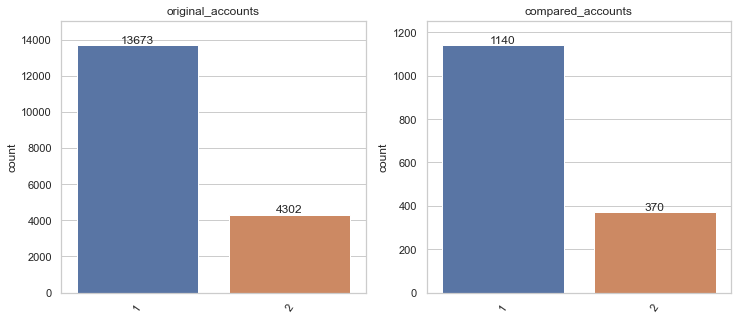

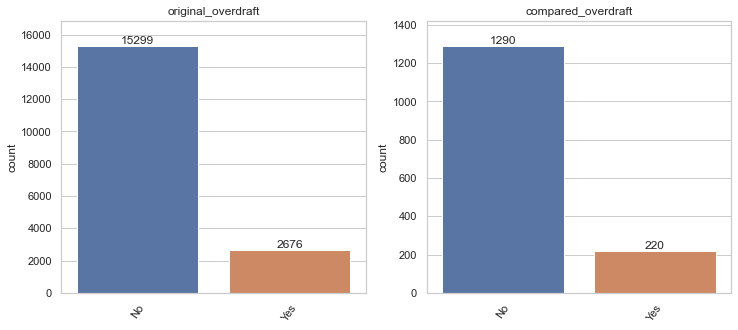

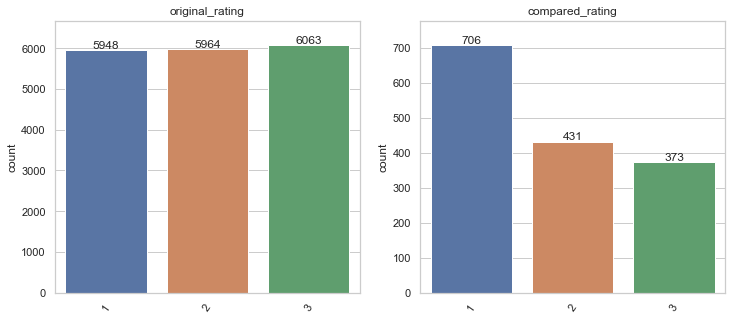

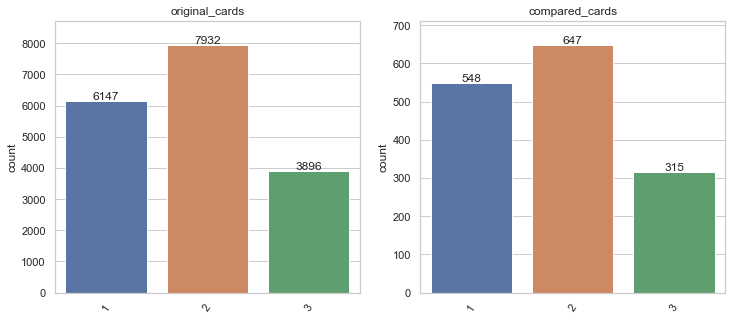

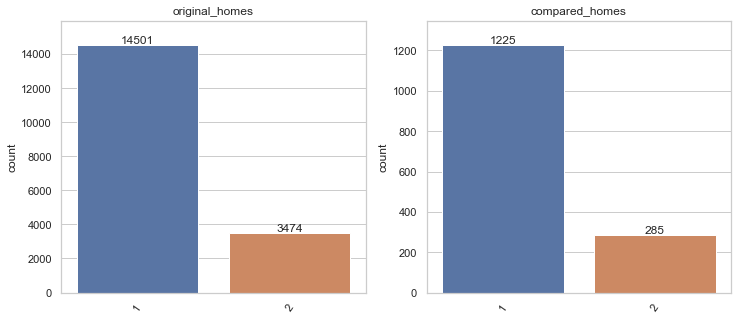

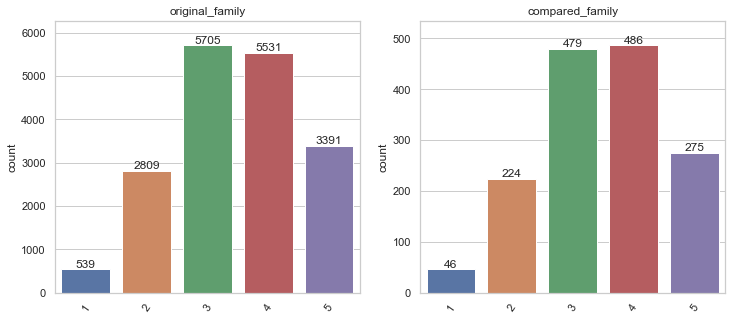

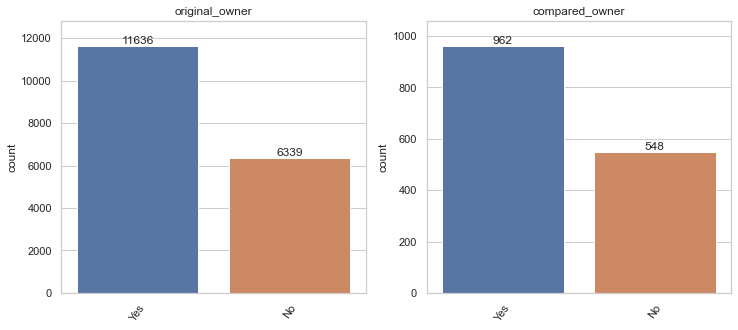

In [114]:
plotCompareDiscrete(categorical, pd.concat([y_train_rus,X_train_rus], axis=1))

There are some features which change its distribution:
* Obviously accept
* reward
* m_type
* rating
  
How could I solve that?  

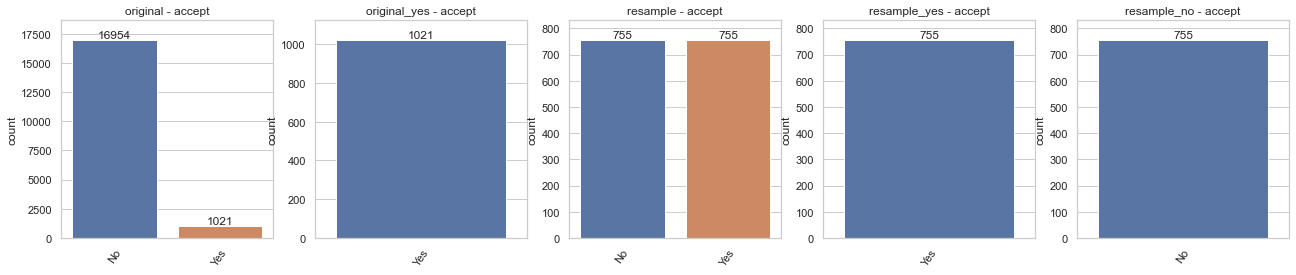

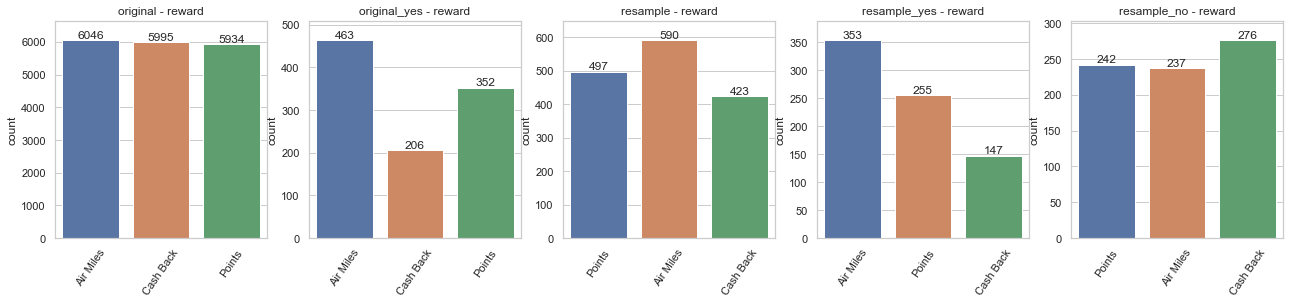

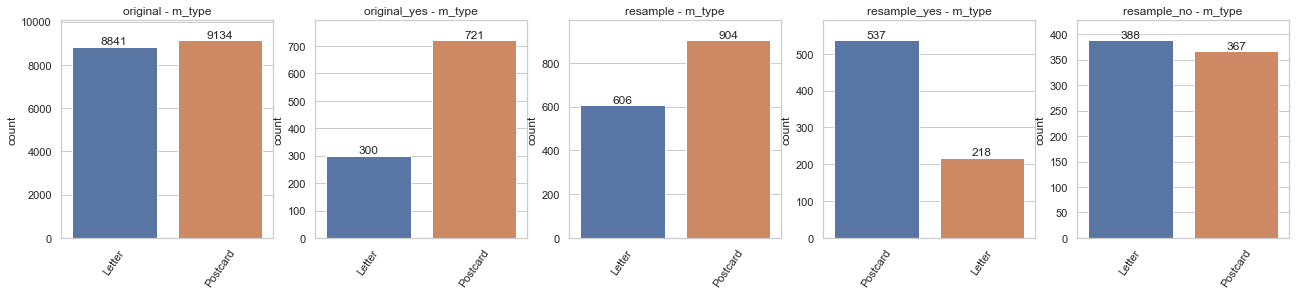

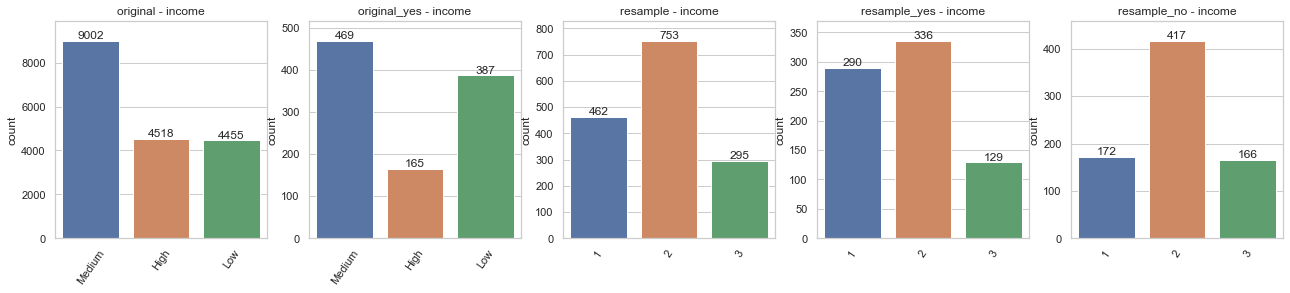

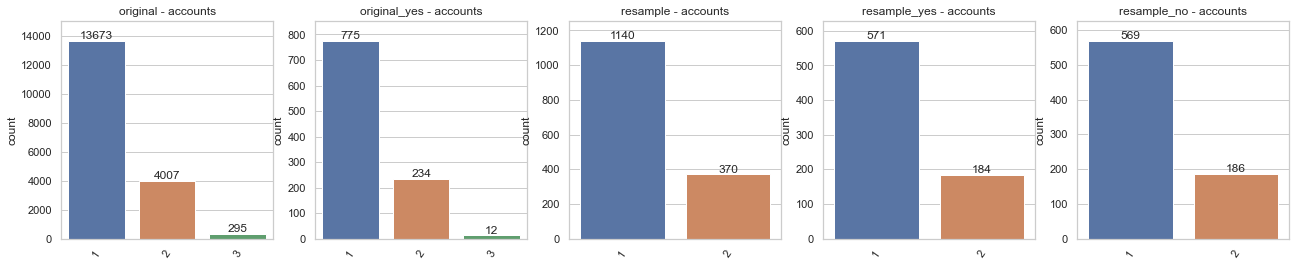

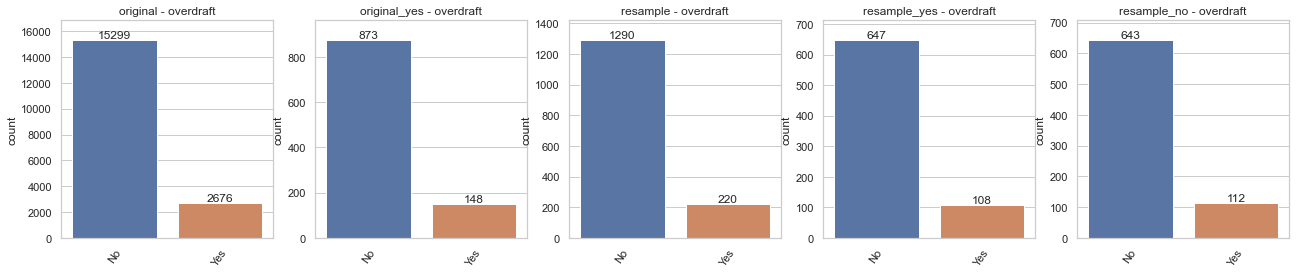

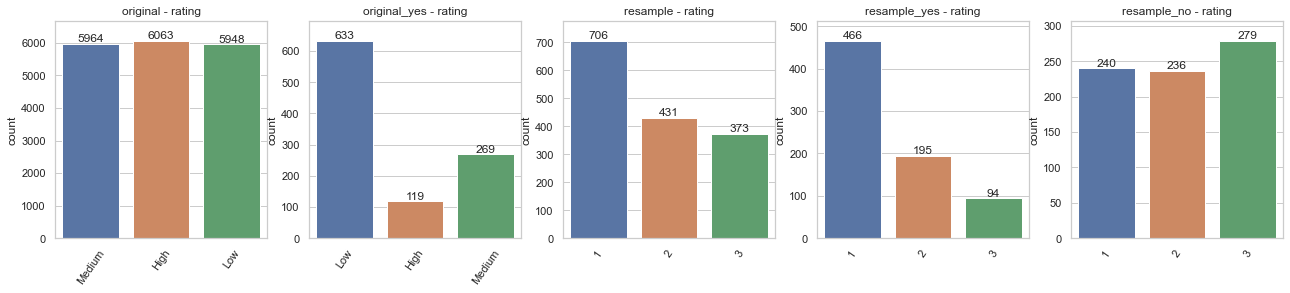

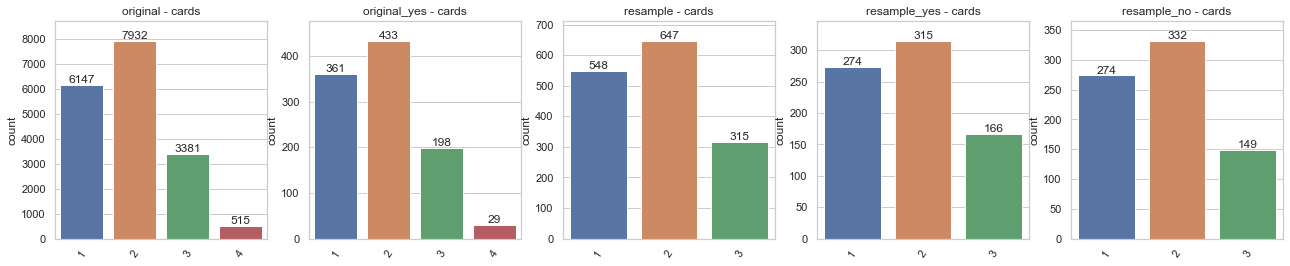

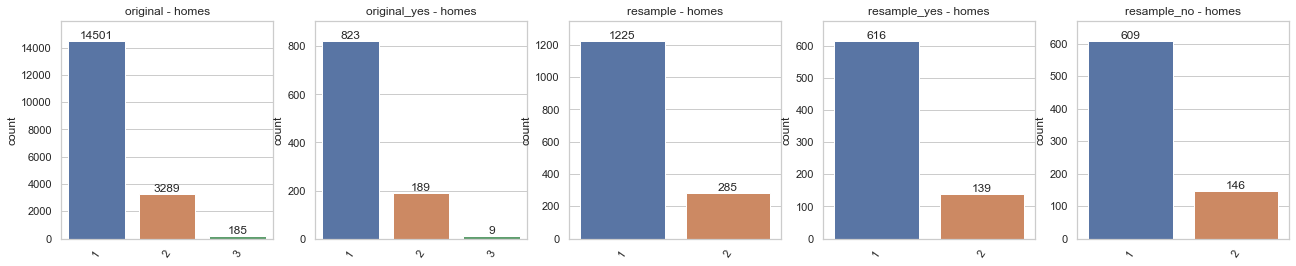

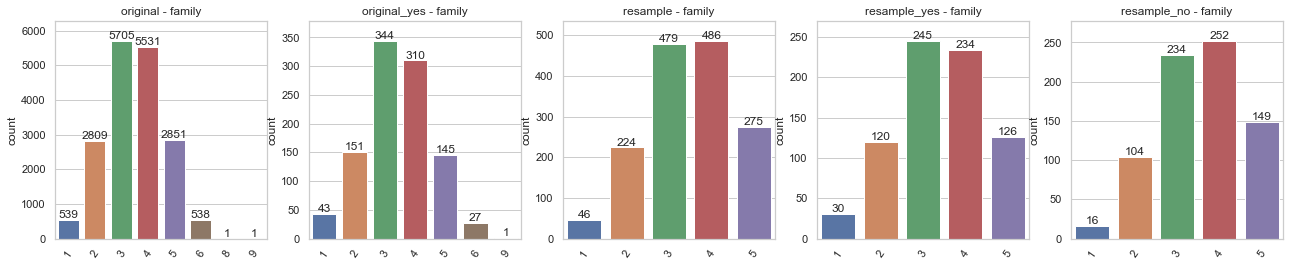

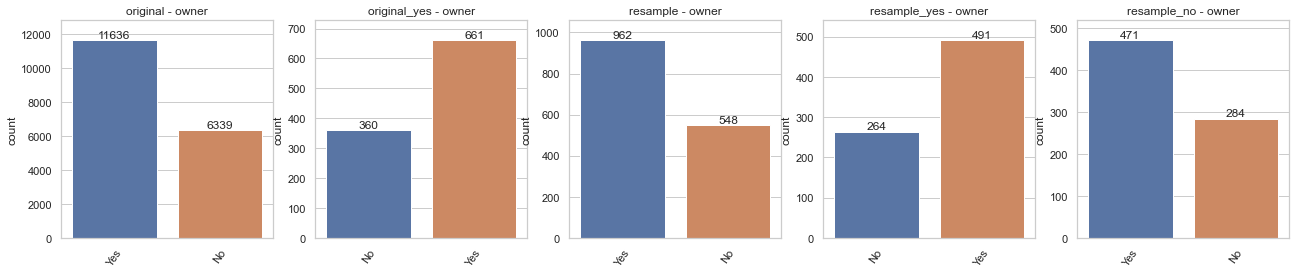

In [122]:
plotCompareResample(disc, pd.concat([y_train_rus,X_train_rus], axis=1), 'accept', pos_label = 'Yes')

## Encode categorical

In [123]:
X_train_rus.dtypes

reward         object
m_type         object
income       category
accounts     category
overdraft      object
rating       category
cards        category
homes        category
family       category
owner          object
balance       float64
dtype: object

In [124]:
# Split numeric categorical
numeric_rus, categorical_rus = numericCategorical(X_train_rus)

In [125]:
numeric_rus_test, categorical_rus_test = numericCategorical(X_test)

I have already encoded the ordinal categories, there was no need indeed. But it is already donde.

In [126]:
def encodeCategoricals(df, encode = False, fit=False, categories='auto'): #ord_mapper, 
    """Encodes a dataframe of categorical variables
    Inputs:
        df - dataframe of categorical variables
        * ord_mapper: for ordinal categories
        - Set fit to True if model OneHotEncoder not yet fitted
        - requires encoder as fitted OneHotEncoder if fit=False
        - categories only required if 
    Subfunctions:
        defOrdinals
    
    returns a dataframe of encoded categorical variables"""
    
    # Define encoder as global to avoid UnboundLocalError
    global encoder
    
    # Defines and encode ordinal variables
    if encode:
        df = defOrdinals(df, mappers_dic = ord_mapper)
    
    # Split Nominal and ordinals
    df_ordinal = df.select_dtypes('category')
    df_nominal = df.select_dtypes('object')
    
    #Save the indices
    indices = df_nominal.index
    
    # OneHotEncoder
    if fit: 
        # Fit
        encoder = OneHotEncoder(categories=categories, sparse=False, drop='first')
        encoder.fit(df_nominal)
    # Transform
    df_nominal_encoded = encoder.transform(df_nominal)
    df_nominal_encoded = pd.DataFrame(df_nominal_encoded, columns = encoder.get_feature_names_out())
    
    # restore indices
    df_nominal_encoded.index = indices
    
    # concat nominal and ordinal into de categorical
    df = pd.concat([df_ordinal,df_nominal_encoded], axis=1)
    
    return df


In [127]:
categorical_rus = encodeCategoricals(categorical_rus, fit=True)

In [128]:
categorical_rus_test = encodeCategoricals(categorical_rus_test, fit=False)

In [129]:
categorical_rus_test

,income,accounts,rating,cards,homes,family,reward_Cash Back,reward_Points,m_type_Postcard,overdraft_Yes,owner_Yes
10162,3,1,1,1,1,2,0.0,0.0,0.0,0.0,0.0
14730,1,1,1,2,1,5,0.0,1.0,1.0,0.0,0.0
15798,3,1,3,2,2,2,0.0,1.0,1.0,0.0,0.0
6200,2,1,3,2,1,4,0.0,1.0,0.0,0.0,1.0
12510,1,1,3,2,1,5,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
15592,3,1,2,2,1,5,0.0,1.0,1.0,0.0,1.0
7865,2,1,3,2,2,2,0.0,1.0,0.0,0.0,1.0
2916,2,1,3,2,1,5,0.0,0.0,1.0,0.0,1.0
2228,1,1,3,2,1,5,0.0,0.0,0.0,0.0,1.0


## Normalize numeric

In [130]:
numeric_rus.std()

balance    554.588053
dtype: float64

In [131]:
def normalize(df):
    """This function normalizes, std = 1, the features of a continuous df"""
    for f in df.columns:
        s = df[f].std()
        df[f] = df[f].apply(lambda x: x/s)
    return df

In [132]:
numeric_rus = normalize(numeric_rus)
numeric_rus.std()

balance    1.0
dtype: float64

In [133]:
numeric_rus_test = normalize(numeric_rus_test)
numeric_rus_test.std()

balance    1.0
dtype: float64

## Concat and scale

In [134]:
X_train_rus = pd.concat([categorical_rus, numeric_rus], axis=1)
X_train_rus.shape

(1510, 12)

In [135]:
X_test_rus = pd.concat([categorical_rus_test, numeric_rus_test], axis=1)
X_test_rus.shape

(4494, 12)

In [ ]:
# MinMax Scale

In [136]:
scaler_rus = MinMaxScaler()
scaler_rus.fit(X_train_rus)
features = scaler_rus.get_feature_names_out()
X_train_rus = scaler_rus.transform(X_train_rus)
X_train_rus = pd.DataFrame(X_train_rus, columns=features)
X_test_rus = scaler_rus.transform(X_test_rus)
X_test_rus = pd.DataFrame(X_test_rus, columns = features)

In [137]:
X_train_rus.shape

(1510, 12)

In [138]:
y_train_rus.shape

(1510,)

In [139]:
X_train_rus.isna().sum()

income              0
accounts            0
rating              0
cards               0
homes               0
family              0
reward_Cash Back    0
reward_Points       0
m_type_Postcard     0
overdraft_Yes       0
owner_Yes           0
balance             0
dtype: int64

In [140]:
X_test_rus.shape

(4494, 12)

## Logistic Regression Model

In [141]:
lr_rus = LogisticRegression(max_iter=1000)
lr_rus.fit(X_train_rus, y_train_rus)
y_pred_test_rus = lr_rus.predict(X_test_rus)

In [144]:
y_pred_train_rus = lr_rus.predict(X_train_rus)

In [142]:
lr_rus.score(X_train_rus,y_train_rus)

0.704635761589404

In [143]:
lr_rus.score(X_test_rus,y_test)

0.6588785046728972

## Evaluate Logistic Regression RUS

In [145]:
# Train Metrics
print("The accuracy in the TRAIN set is: {:.2f}".format(accuracy_score(y_train_rus,y_pred_train_rus)))
print("The precision in the TRAIN set is: {:.2f}".format(precision_score(y_train_rus,y_pred_train_rus, pos_label = 'Yes')))
print("The recall in the TRAIN set is: {:.2f}".format(recall_score(y_train_rus,y_pred_train_rus, pos_label = 'Yes')))
print("The F1 in the TRAIN set is: {:.2f}".format(f1_score(y_train_rus,y_pred_train_rus, pos_label = 'Yes')))
print("The Kappa in the TRAIN set is: {:.2f}".format(cohen_kappa_score(y_train_rus,y_pred_train_rus)))


The accuracy in the TRAIN set is: 0.70
The precision in the TRAIN set is: 0.70
The recall in the TRAIN set is: 0.72
The F1 in the TRAIN set is: 0.71
The Kappa in the TRAIN set is: 0.41


In [146]:
# Test Metrics
print("The accuracy in the TEST set is: {:.2f}".format(accuracy_score(y_test,y_pred_test_rus)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_test,y_pred_test_rus, pos_label = 'Yes')))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test,y_pred_test_rus, pos_label = 'Yes')))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test,y_pred_test_rus, pos_label = 'Yes')))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test,y_pred_test_rus)))

The accuracy in the TEST set is: 0.66
The precision in the TEST set is: 0.12
The recall in the TEST set is: 0.72
The F1 in the TEST set is: 0.20
The Kappa in the TEST set is: 0.11


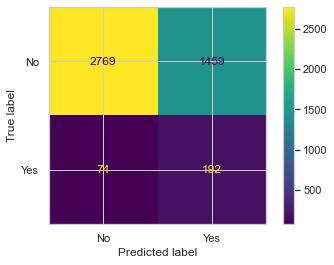

In [147]:
cm_test_rus = confusion_matrix(y_test,y_pred_test_rus)
disp_rus = ConfusionMatrixDisplay(confusion_matrix=cm_test_rus, display_labels=lr_rus.classes_)
disp_rus.plot()
plt.show()

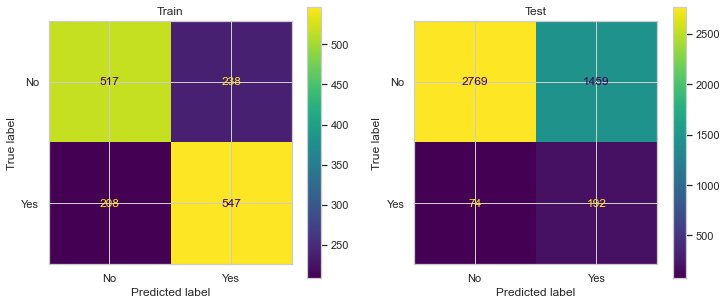

In [151]:
f, ax = plt.subplots(1,2, figsize=(12,5))
cm_train_rus = confusion_matrix(y_train_rus,y_pred_train_rus)
cm_test_rus = confusion_matrix(y_test,y_pred_test_rus)
disp_rus_train = ConfusionMatrixDisplay(confusion_matrix=cm_train_rus, display_labels=lr_rus.classes_)
disp_rus = ConfusionMatrixDisplay(confusion_matrix=cm_test_rus, display_labels=lr_rus.classes_)
disp_rus_train.plot(ax = ax[0])
disp_rus_train.ax_.set_title('Train')
disp_rus.plot(ax = ax[1])
disp_rus.ax_.set_title('Test')
plt.show()

## function evaluateLogistic

In [177]:
def evaluateLogistic(X_train, X_test, y_train, y_test, pos_label = 'Yes'):
    """Creates a Logistic Regression and evaluates it
    Inputs:
        preprocessed data
        positive label for the metrics
    returns:
        lr - fitted logistic regression"""
    
    # Create the model and predition
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    y_pred_train = lr_rus.predict(X_train)
    y_pred_test = lr.predict(X_test)
    
    # Compute train score
    train_score = lr.score(X_train,y_train)
    
    # Print the Train Metrics
    print("The accuracy in the TRAIN set is: {:.1f}".format(100*train_score))
    print("The precision in the TRAIN set is: {:.2f}".format(100*precision_score(y_train,y_pred_train, pos_label = pos_label)))
    print("The recall in the TRAIN set is: {:.2f}".format(100*recall_score(y_train,y_pred_train, pos_label = pos_label)))
    print("The F1 in the TRAIN set is: {:.2f}".format(100*f1_score(y_train,y_pred_train, pos_label = pos_label)))
    print("The Kappa in the TRAIN set is: {:.2f}".format(100*cohen_kappa_score(y_train,y_pred_train)))
    
    # Print the Test Metrics
    print()
    print("The accuracy in the TEST set is: {:.2f}".format(100*accuracy_score(y_test,y_pred_test)))
    print("The precision in the TEST set is: {:.2f}".format(100*precision_score(y_test,y_pred_test, pos_label = pos_label)))
    print("The recall in the TEST set is: {:.2f}".format(100*recall_score(y_test,y_pred_test, pos_label = pos_label)))
    print("The F1 in the TEST set is: {:.2f}".format(100*f1_score(y_test,y_pred_test, pos_label = pos_label)))
    print("The Kappa in the TEST set is: {:.2f}".format(100*cohen_kappa_score(y_test,y_pred_test)))
    
    # Display the two confussion matrices
    f, ax = plt.subplots(1,2, figsize=(12,5))
    cm_train = confusion_matrix(y_train,y_pred_train)
    cm_test = confusion_matrix(y_test,y_pred_test)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=lr.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=lr.classes_)
    disp_train.plot(ax = ax[0])
    disp_train.ax_.set_title('Train')
    disp.plot(ax = ax[1])
    disp.ax_.set_title('Test')
    disp.ax_.set_ylabel(None)
    plt.show()

    
    return lr
    
    

### Logits

In [265]:
logits_rus = np.log(lr_rus.predict_proba(X_train_rus)[:,1]/(1-lr_rus.predict_proba(X_train_rus)[:,1]))

In [266]:
logits_rus = pd.Series(logits_rus)

In [267]:
X_logits_rus = pd.concat([X_train_rus,logits_rus], axis =1)
X_logits_rus

,income,accounts,rating,cards,homes,family,reward_Cash Back,reward_Points,m_type_Postcard,overdraft_Yes,Owner_Yes,balance,0
0,0.0,0.0,0.0,0.5,0.0,1.00,0.0,1.0,0.0,0.0,1.0,0.401094,0.395691
1,0.5,1.0,1.0,0.0,0.0,0.50,0.0,0.0,0.0,0.0,1.0,0.284933,-1.266904
2,0.5,1.0,0.0,0.0,0.0,0.25,0.0,0.0,1.0,0.0,1.0,0.224747,1.692268
3,0.5,0.0,0.5,0.5,1.0,1.00,0.0,1.0,0.0,0.0,0.0,0.533670,-1.062720
4,0.5,0.0,0.0,0.5,1.0,1.00,0.0,1.0,1.0,0.0,1.0,0.153199,1.079361
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,0.5,1.0,0.5,0.0,0.0,0.75,0.0,0.0,0.0,0.0,1.0,0.270202,-0.458568
1506,0.5,0.0,0.0,0.5,1.0,0.50,0.0,0.0,0.0,0.0,1.0,0.223064,0.722738
1507,0.0,1.0,0.0,0.5,1.0,0.75,0.0,0.0,1.0,0.0,1.0,0.287879,2.034470
1508,0.0,0.0,0.0,0.0,1.0,1.00,1.0,0.0,0.0,0.0,0.0,0.564394,-0.504458


,income,accounts,rating,cards,homes,family,reward_Cash Back,reward_Points,m_type_Postcard,overdraft_Yes,Owner_Yes,balance,0
income,1.000000,-0.015587,0.045455,0.004134,0.030298,0.005098,0.024845,-0.018205,0.005755,0.006257,-0.028766,-0.004545,-0.321292
accounts,-0.015587,1.000000,0.029427,-0.031015,-0.015088,-0.016823,-0.019369,0.000716,0.020387,-0.025781,0.042519,0.009989,-0.004255
rating,0.045455,0.029427,1.000000,0.012738,0.007987,0.043296,0.009549,-0.040407,-0.067287,-0.001112,0.008691,0.009372,-0.710410
cards,0.004134,-0.031015,0.012738,1.000000,-0.011487,-0.024735,0.026445,-0.015826,0.020979,-0.033108,-0.010345,0.032169,0.031152
homes,0.030298,-0.015088,0.007987,-0.011487,1.000000,0.074632,0.026993,-0.002898,-0.026319,-0.016901,-0.044241,0.017226,-0.027222
family,0.005098,-0.016823,0.043296,-0.024735,0.074632,1.000000,0.011714,-0.029628,-0.031073,0.021723,-0.019367,0.049115,-0.149041
reward_Cash Back,0.024845,-0.019369,0.009549,0.026445,0.026993,0.011714,1.000000,-0.436947,-0.021782,-0.002630,-0.029098,-0.011008,-0.419346
reward_Points,-0.018205,0.000716,-0.040407,-0.015826,-0.002898,-0.029628,-0.436947,1.000000,-0.024559,-0.001640,-0.004783,-0.014368,0.042863
m_type_Postcard,0.005755,0.020387,-0.067287,0.020979,-0.026319,-0.031073,-0.021782,-0.024559,1.000000,0.004945,0.008638,0.079034,0.499836
overdraft_Yes,0.006257,-0.025781,-0.001112,-0.033108,-0.016901,0.021723,-0.002630,-0.001640,0.004945,1.000000,-0.004524,-0.011413,-0.018515


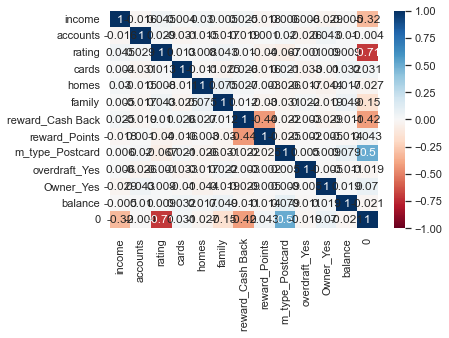

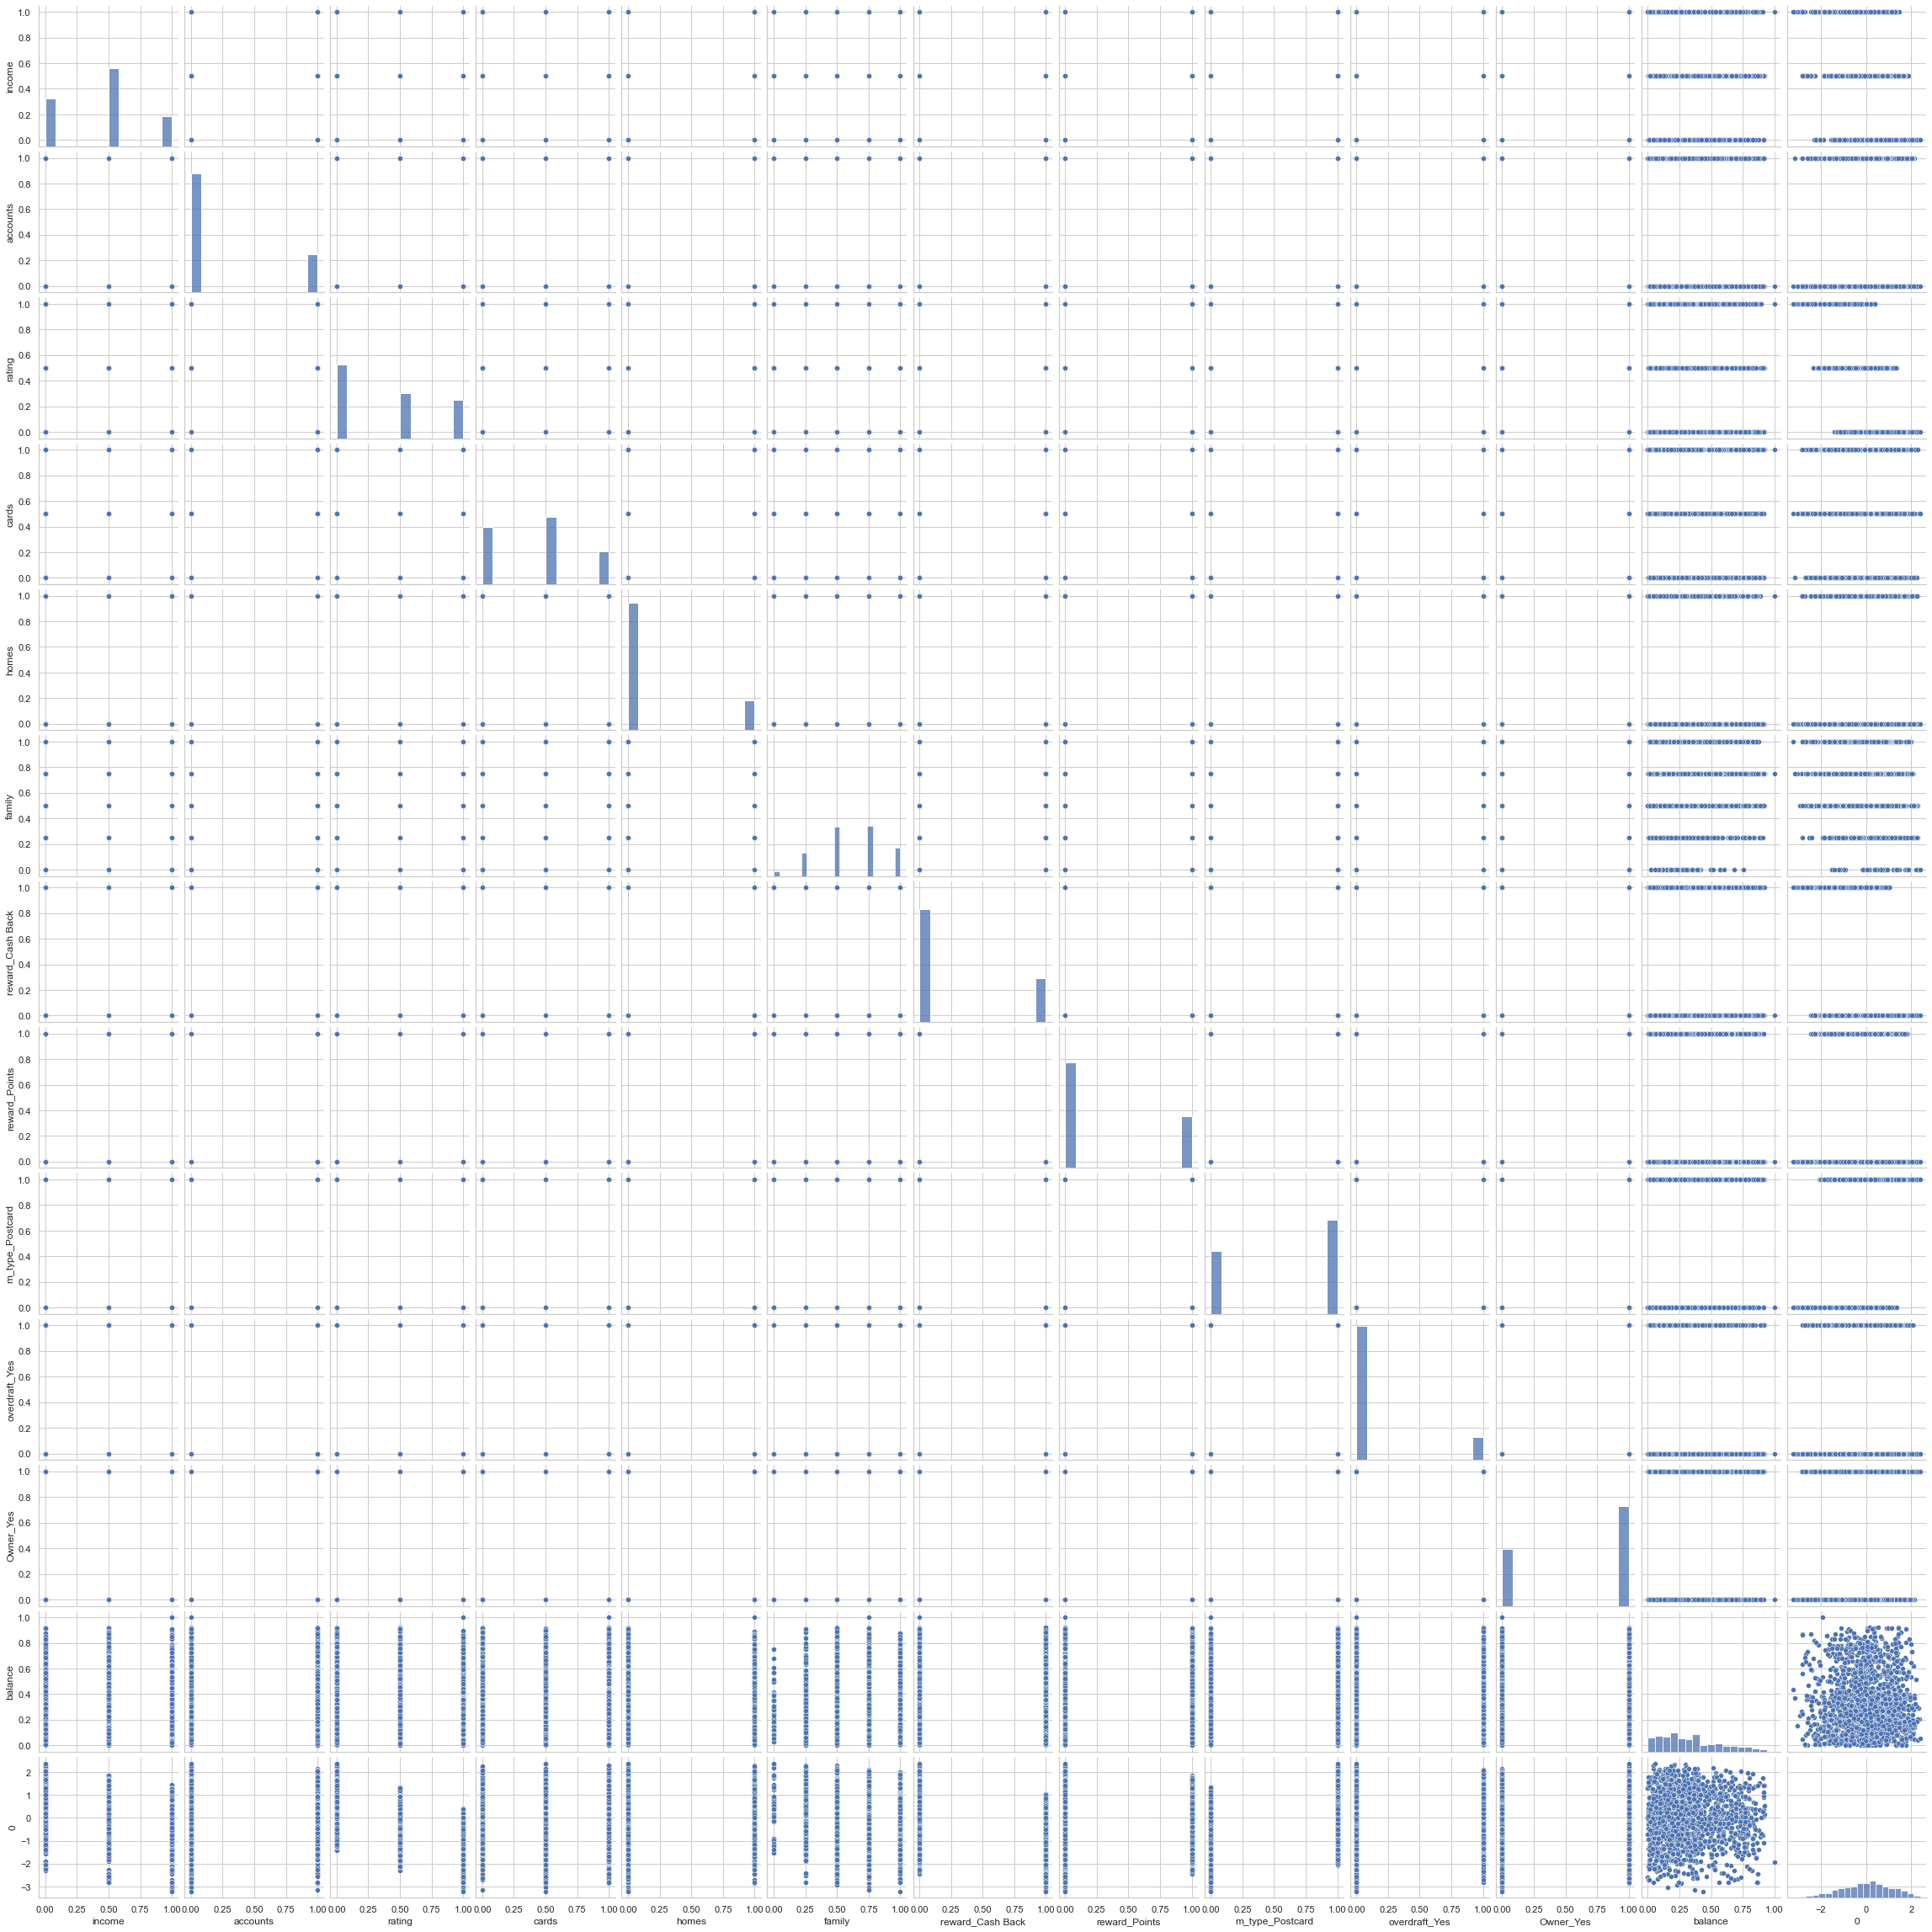

In [268]:
corrPlots(X_logits_rus)

# Up and Down sampling manual

## Manual Sampling

In [153]:
# Sample size
majority_class = y_train[y_train == 'No']
minority_class = y_train[y_train == 'Yes']

In [154]:
len(majority_class)

12724

In [155]:
len(minority_class)

755

In [156]:
size = int((len(majority_class)+len(minority_class))/2)
size

6739

In [157]:
len(X_train)

13479

In [158]:
majority_indices = majority_class.index
minority_indices = minority_class.index

In [ ]:
# Resample based on indices

In [159]:
major_new_indices = np.random.choice(majority_indices, size = int(size/2), replace = False)
minor_new_indices = np.random.choice(minority_indices, size = int(size/2), replace = True)

In [160]:
len(major_new_indices)

3369

In [161]:
new_indices = list(np.concatenate((major_new_indices,minor_new_indices)))
len(new_indices)

6738

In [162]:
new_indices

[15076,
 7205,
 7904,
 5810,
 8145,
 7121,
 1292,
 11706,
 3431,
 15226,
 13280,
 13441,
 8794,
 2272,
 8470,
 7435,
 4860,
 1583,
 10413,
 11341,
 17664,
 6602,
 10586,
 4961,
 12594,
 6026,
 17485,
 15489,
 17890,
 9931,
 10058,
 8728,
 9711,
 7001,
 6240,
 8813,
 5772,
 3449,
 6987,
 12988,
 9946,
 2962,
 7268,
 10226,
 9434,
 4162,
 1600,
 11372,
 2196,
 8741,
 2801,
 12344,
 10376,
 11227,
 3298,
 14196,
 6970,
 16220,
 6253,
 195,
 8043,
 10417,
 6904,
 10354,
 6772,
 17718,
 9726,
 2359,
 778,
 12559,
 12634,
 2452,
 17034,
 5841,
 14516,
 17491,
 98,
 4057,
 1927,
 17379,
 5248,
 7847,
 8962,
 4937,
 12595,
 6087,
 7881,
 15338,
 9708,
 2765,
 17199,
 3139,
 15739,
 16534,
 2954,
 16529,
 17791,
 13748,
 6431,
 16205,
 1601,
 16509,
 13092,
 9954,
 4933,
 3540,
 15545,
 16571,
 13144,
 2399,
 10240,
 15123,
 1889,
 11038,
 17464,
 13221,
 14487,
 6336,
 2042,
 1526,
 9707,
 14868,
 3273,
 894,
 8243,
 9339,
 3028,
 1722,
 297,
 7831,
 15994,
 9999,
 13037,
 9276,
 11522,
 17232

In [163]:
X_train_man = X_train.loc[new_indices,:] 
X_train_man.shape

(6738, 11)

In [164]:
y_train_man = y_train[new_indices]
y_train_man.shape

(6738,)

## Plot discrete comparision

In [165]:
X_train_man.head()

,reward,m_type,income,accounts,overdraft,rating,cards,homes,family,owner,balance
15076,Air Miles,Postcard,1,2,No,3,3,1,3,Yes,567.0
7205,Points,Postcard,2,1,No,2,3,1,5,Yes,394.0
7904,Air Miles,Postcard,2,1,No,2,1,2,3,Yes,390.0
5810,Points,Letter,3,1,No,1,3,1,3,Yes,139.0
8145,Cash Back,Letter,3,1,No,2,1,1,4,No,1028.0


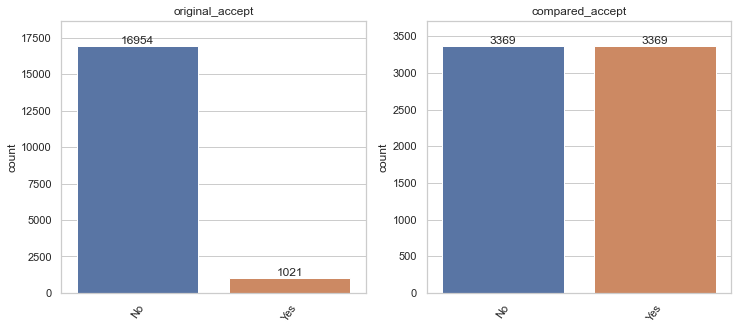

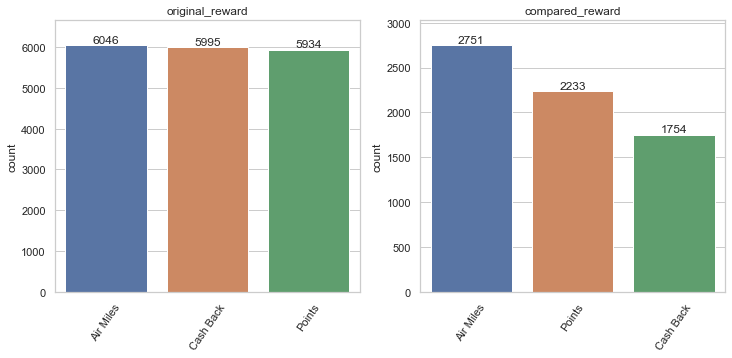

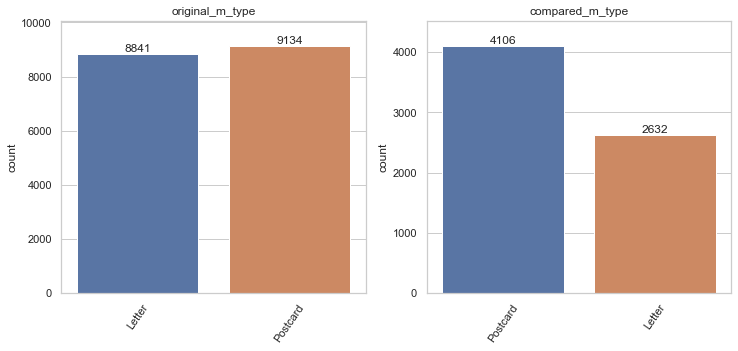

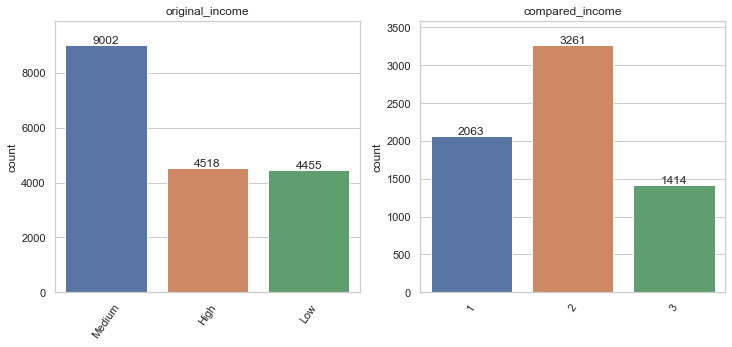

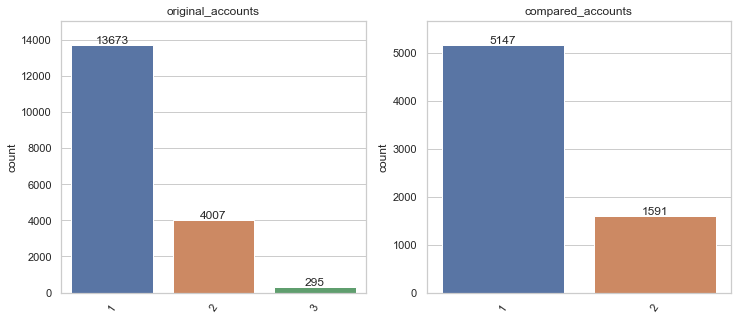

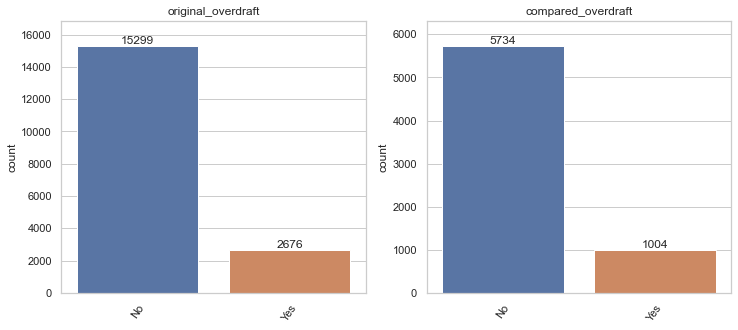

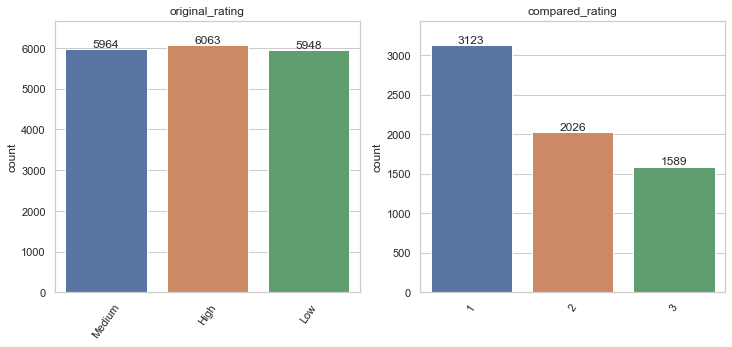

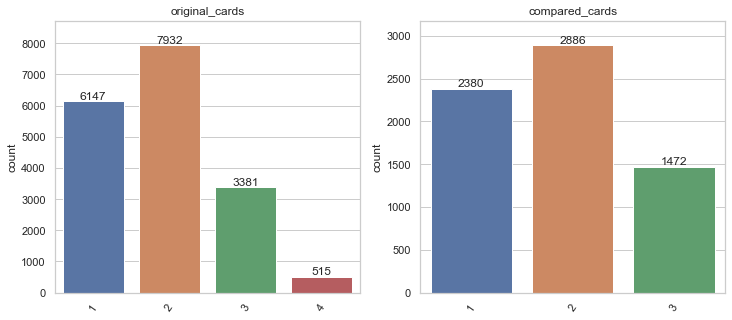

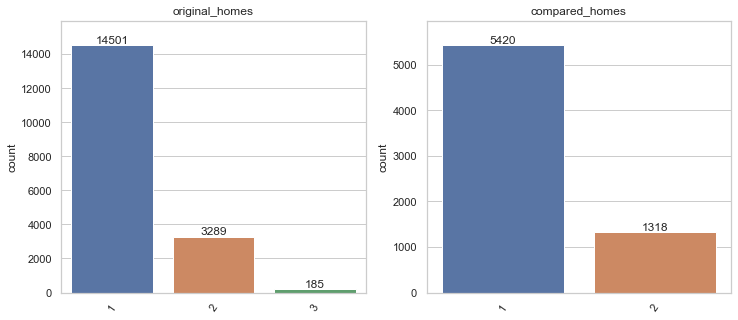

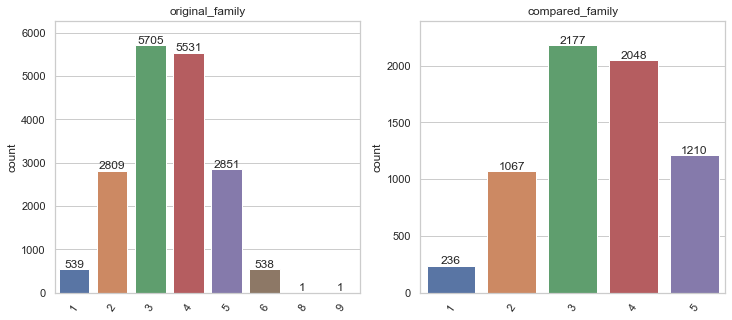

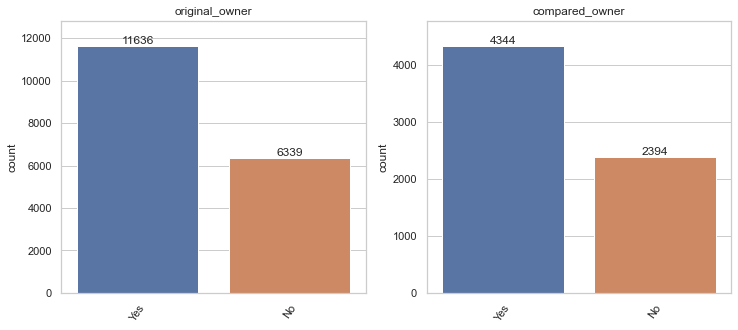

In [166]:
plotCompareDiscrete(disc, pd.concat([y_train_man,X_train_man.iloc[:,:-1]],axis=1))

There are features which do not have the same proportion:
* reward
* m_type
* compared_income
* rating

### function plotCompareResample 

In [121]:
def plotCompareResample(disc, resample, target, pos_label = 'Yes'):
    """Plot a comparision among the original categorical variables with the resampled
    dataframe and the subsets of the resample with positve and non positive label"""

    disc_pos = disc[disc[target] == pos_label]
    
    resample_pos = resample[resample[target] == pos_label]
    resample_neg = resample[resample[target] != pos_label]


    for i,c in enumerate(disc.columns):
            f, ax = plt.subplots(1,5, figsize=(22,4))

            sns.countplot(x=c,data=disc, ax=ax[0])
            sns.countplot(x=c,data=disc_pos, ax=ax[1])
            sns.countplot(x=c,data=resample,ax=ax[2])
            sns.countplot(x=c,data=resample_pos,ax=ax[3])
            sns.countplot(x=c,data=resample_neg,ax=ax[4])


            ax[0].set_title('original - %s' %(c))
            ax[0].set_xlabel(None)
            ax[0].tick_params(axis='x', labelrotation=55)
            
            ax[1].set_title('original_yes - %s' %(c))
            ax[1].set_xlabel(None)
            ax[1].tick_params(axis='x', labelrotation=55)

            ax[2].set_title('resample - %s' %(c))
            ax[2].set_xlabel(None)
            ax[2].tick_params(axis='x', labelrotation=55)

            ax[3].set_title('resample_yes - %s' %(c))
            ax[3].set_xlabel(None)
            ax[3].tick_params(axis='x', labelrotation=55)

            ax[4].set_title('resample_no - %s' %(c))
            ax[4].set_xlabel(None)
            ax[4].tick_params(axis='x', labelrotation=55)

                # annotate
            ax[0].bar_label(ax[0].containers[0], label_type='edge')
            ax[1].bar_label(ax[1].containers[0], label_type='edge')
            ax[2].bar_label(ax[2].containers[0], label_type='edge')
            ax[3].bar_label(ax[3].containers[0], label_type='edge')
            ax[4].bar_label(ax[4].containers[0], label_type='edge')

                # pad the spacing between the number and the edge of the figure
            ax[0].margins(y=0.1)
            ax[1].margins(y=0.1)
            ax[2].margins(y=0.1)
            ax[3].margins(y=0.1)
            ax[4].margins(y=0.1)


            plt.show()

    return None

### plot compare resample

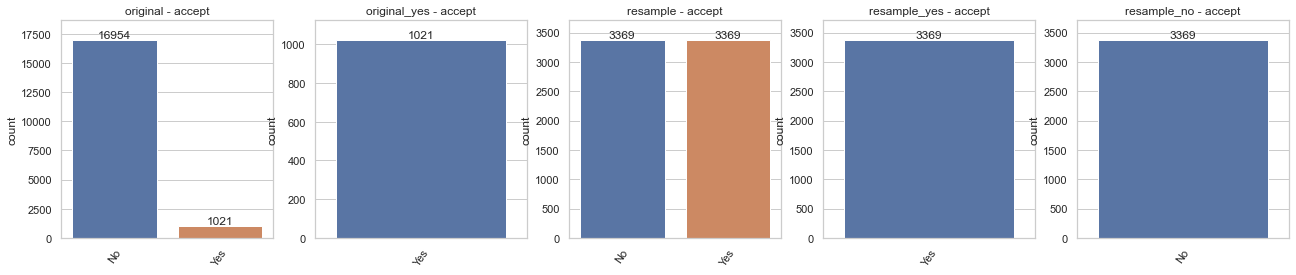

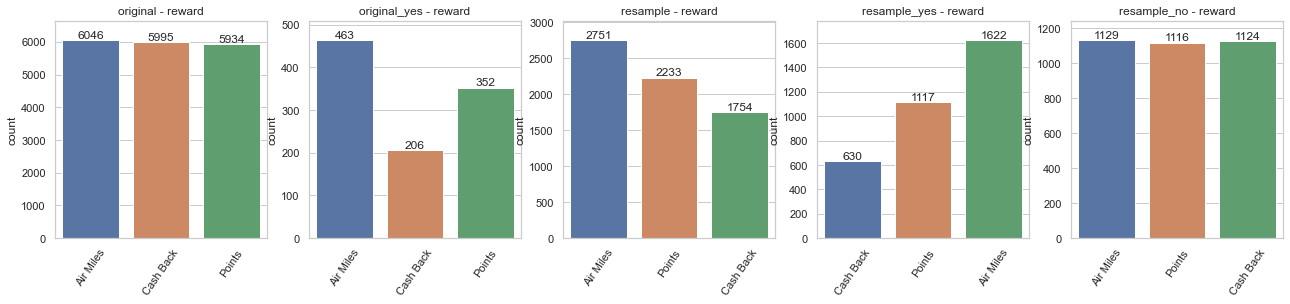

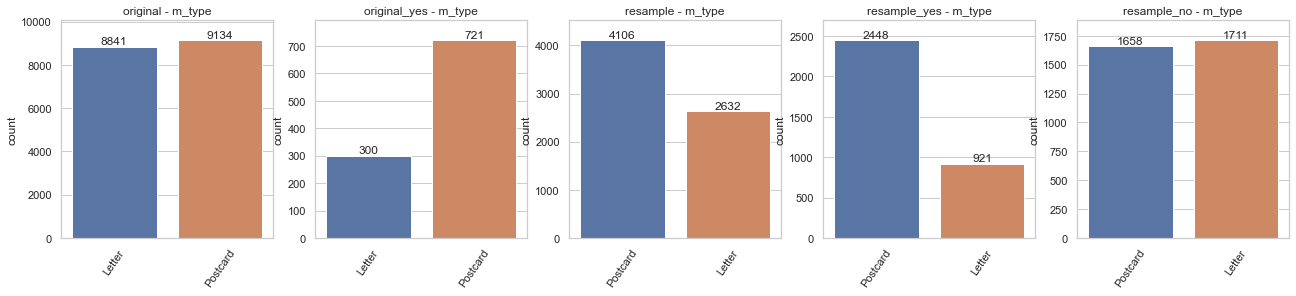

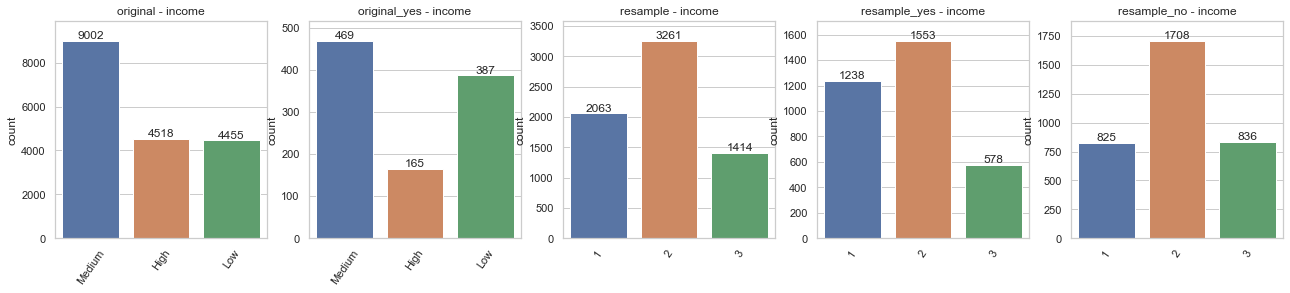

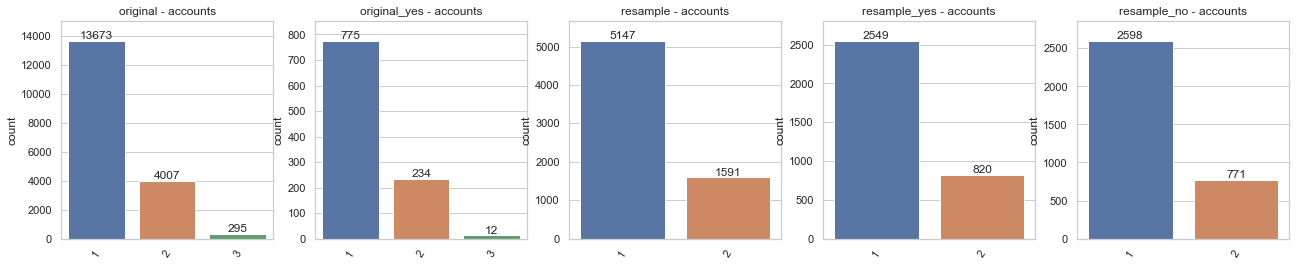

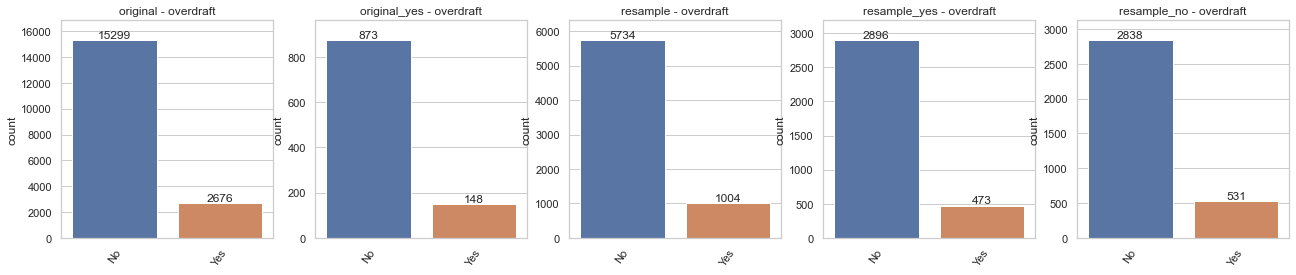

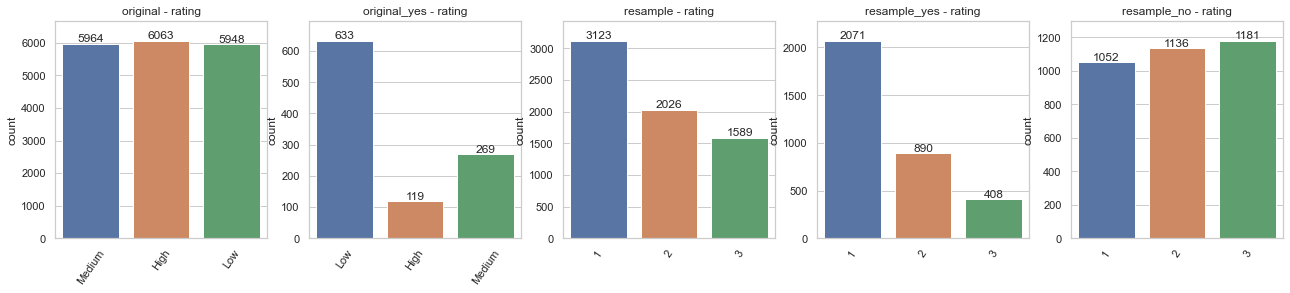

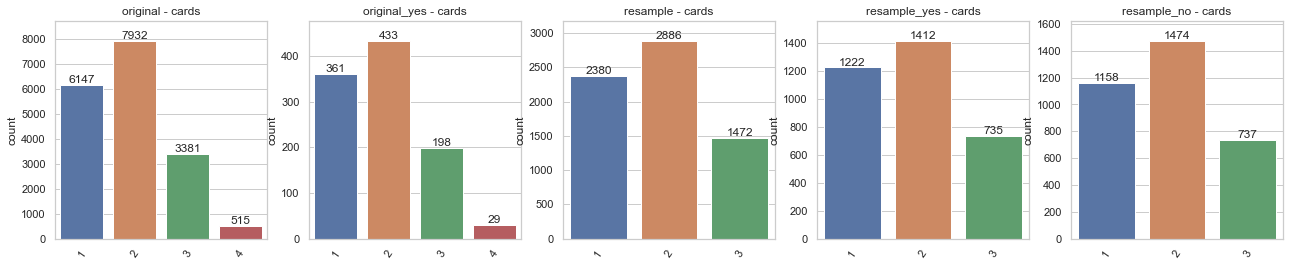

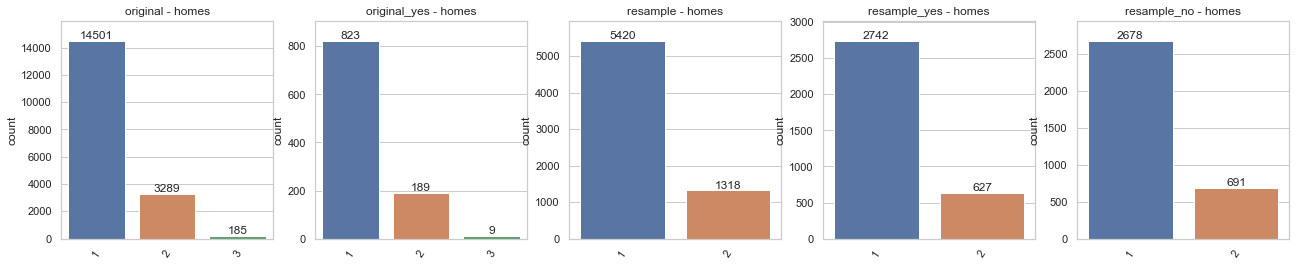

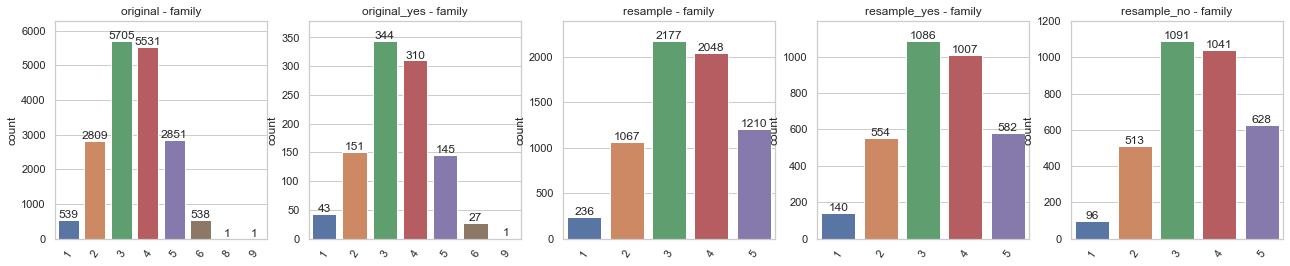

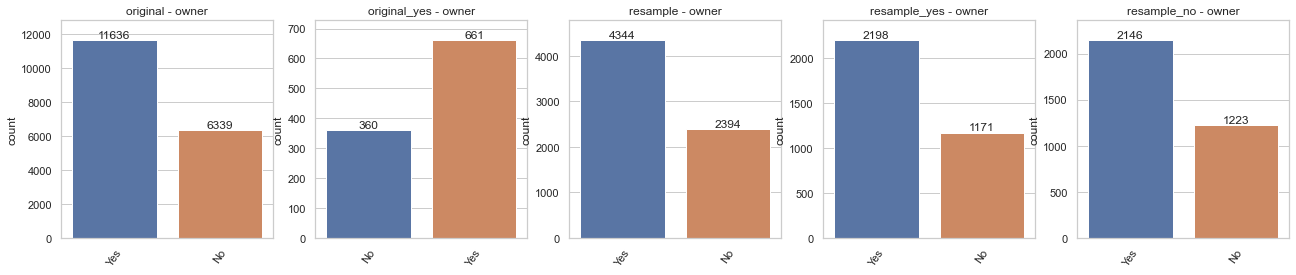

In [167]:
plotCompareResample(disc, pd.concat([y_train_man,X_train_man.iloc[:,:-1]],axis=1), 
                    'accept', pos_label = 'Yes')


## Finish preprocessing

### preprocess functions

Copied and adapted

In [168]:
def preprocess(X_train, X_test, y_train, y_test, drop_feat=[], add_feat=[], categories = 'auto'):
    """Based on processData.Preprocess Data after resampling.
    Inputs: 
        X_train, X_test, y_train, y_test
        drop_feat: list of features to be dropped
        add_feat: (time-like feature to be merged after logTransform and normalize)
        categories
    Sub-functions:
        numericCategorical
        removeOutliers
        logTransform
        normalize
        encodeCategoricals
    Returns: 
        X_train (without outliers) (normalized, encoded and scaled) 
        X_test (normalized, encoded and scaled)
        y_train (without outliers)
        y_test
    """
    
    # Train test split
    #X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)
    
    
    # Drop some features
    if len(drop_feat)>0:
        X_train.drop(columns=drop_feat, inplace=True, errors='ignore')
        X_test.drop(columns=drop_feat, inplace=True, errors='ignore')
    
    # Split X_train and X_test into continuous and categorical
    X_train_continuous, X_train_categorical = numericCategorical(X_train)
    X_test_continuous, X_test_categorical = numericCategorical(X_test)
    
    # Remove outliers from train set (reduce skewness - logTransform)
    #X_train_continuous, X_train_categorical, y_train = removeOutliers(X_train_continuous, X_train_categorical, y_train)
    
    # LogTransform X_test
    X_test_continuous = logTransform(X_test_continuous)
    
    # Normalize continuos train and test
    X_train_continuous = normalize(X_train_continuous)
    X_test_continuous = normalize(X_test_continuous)
    
    
    # Encode X_train_categorical
    X_train_categorical = encodeCategoricals(X_train_categorical, fit=True, categories=categories)
    # Encode X_test_categorical
    X_test_categorical = encodeCategoricals(X_test_categorical)
    
    
    # Concat continuous and categorical
    X_train = pd.concat([X_train_continuous,X_train_categorical], axis=1)
    X_test = pd.concat([X_test_continuous,X_test_categorical], axis=1)
    
    # Merge Additional Features
    if len(add_feat)>0:
        X_train = pd.merge(X_train, add_feat,how='left',left_index=True, right_index=True)
        X_test = pd.merge(X_test, add_feat, how='left',left_index=True, right_index=True)
    
    # MinMax Scale
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    features = scaler.get_feature_names_out()
    X_train = scaler.transform(X_train)
    X_train = pd.DataFrame(X_train, columns=features)
    X_test = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test, columns = features)
    
    return X_train, X_test, y_train, y_test
    
    

In [171]:
def removeOutliers(X_train_continuous, X_train_categorical, y_train):
    """This function remove the outliers in the training set:
    X_train_continuous
    X_train_categorical
    y_train"""
    
    # LogTransform: check skewness in the continuous features and logTransform them
    X_train_continuous = logTransform(X_train_continuous)
    
    # Plots outliers
    plotOutliers(X_train_continuous)
    
    # Counts outliers and gets its info
    outliers_data = countOutliers(X_train_continuous)
    
    
    # Removing the outliers
    if len(outliers_data) > 0:
        # Get the indices of the outliers
        indices = pd.Index([])
        for i in outliers_data.index:
            indices = indices.append(out_data.loc[i,'outliers_df'].index)
        indices = indices.drop_duplicates()
        
        # Drop the outliers
        X_train_continuous.drop(index=indices, inplace=True)
        X_train_categorical.drop(index=indices, inplace=True)
        y_train.drop(index=indices, inplace=True)
    
    else:
        print('There was not found any outlier.')
    
    return X_train_continuous, X_train_categorical, y_train
    

In [170]:
def logTransform(df):
    """Checks skewness higher than 2 and apply log transform on those variables"""
    skewed = df.skew()[df.skew()>2]
    if len(skewed) > 0:
        for c in skewed.index:
            df[c] = df[c].apply(lambda x: np.log10(x) if x != 0 else x)
                
    return df

### Preprocess

In [172]:
X_train_man_p, X_test_man_p, y_train_man_p, y_test_man_p = preprocess(X_train_man, X_test, y_train_man, y_test)



In [ ]:
# Check

In [175]:
X_train_man.shape

(6738, 11)

In [176]:
X_train_man_p.shape

(6738, 12)

## Evaluate Logistic Regression

/Users/albertomengual/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


The accuracy in the TRAIN set is: 69.5
The precision in the TRAIN set is: 51.62
The recall in the TRAIN set is: 44.38
The F1 in the TRAIN set is: 47.73
The Kappa in the TRAIN set is: 2.79

The accuracy in the TEST set is: 66.22
The precision in the TEST set is: 11.55
The recall in the TEST set is: 70.68
The F1 in the TEST set is: 19.85
The Kappa in the TEST set is: 10.77


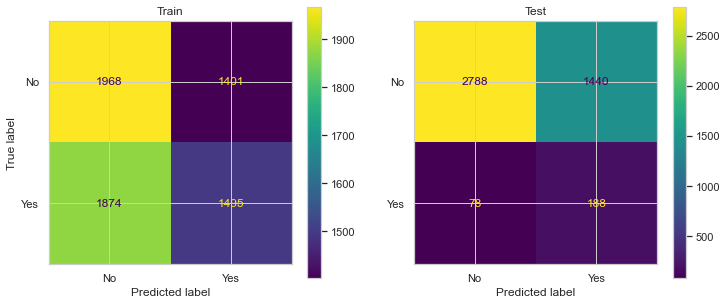

In [178]:
lr_man = evaluateLogistic(X_train_man_p, X_test_man_p, y_train_man_p, y_test_man_p)

# Manual Balanced Downsampling

In [ ]:
# X_train_man, X_test, y_train_man, y_test

In [203]:
# Check shape
X_train_man.shape

(6738, 11)

In [204]:
y_train_man.shape

(6738,)

In [205]:
manual_resample = pd.concat([X_train_man,y_train_man],axis=1)
manual_resample.shape

(6738, 12)

In [206]:
manual_resample.columns

Index(['reward', 'm_type', 'income', 'accounts', 'overdraft', 'rating',
       'cards', 'homes', 'family', 'owner', 'balance', 'accept'],
      dtype='object')

In [195]:
imbalance_columns = ['reward','m_type', 'rating','accept']
# imbalance_columns = ['reward','Owner', 'family', 'homes', 'cards', 'overdraft', 'accounts', 'income', 'accept']
# imbalance_columns = ['homes','accounts','income', 'accept']

In [207]:
manual_grouped = manual_resample.groupby(imbalance_columns)[imbalance_columns]

In [208]:
manual_grouped2 = manual_resample.groupby(imbalance_columns)

In [183]:
#manual_grouped_rating = manual_resample.groupby('rating')['rating']

In [209]:
manual_grouped.head()

,reward,m_type,rating,accept
15076,Air Miles,Postcard,3,No
7205,Points,Postcard,2,No
7904,Air Miles,Postcard,2,No
5810,Points,Letter,1,No
8145,Cash Back,Letter,2,No
...,...,...,...,...
13759,Cash Back,Letter,3,Yes
13759,Cash Back,Letter,3,Yes
6659,Cash Back,Letter,2,Yes
4761,Cash Back,Letter,2,Yes


In [210]:
manual_grouped2.head()

,reward,m_type,income,accounts,overdraft,rating,cards,homes,family,owner,balance,accept
15076,Air Miles,Postcard,1,2,No,3,3,1,3,Yes,1.017280,No
7205,Points,Postcard,2,1,No,2,3,1,5,Yes,0.706893,No
7904,Air Miles,Postcard,2,1,No,2,1,2,3,Yes,0.699716,No
5810,Points,Letter,3,1,No,1,3,1,3,Yes,0.249386,No
8145,Cash Back,Letter,3,1,No,2,1,1,4,No,1.844380,No
...,...,...,...,...,...,...,...,...,...,...,...,...
13759,Cash Back,Letter,1,1,No,3,1,1,4,Yes,0.566949,Yes
13759,Cash Back,Letter,1,1,No,3,1,1,4,Yes,0.566949,Yes
6659,Cash Back,Letter,2,2,No,2,2,1,2,Yes,0.484419,Yes
4761,Cash Back,Letter,1,1,No,2,1,1,5,Yes,0.529272,Yes


In [151]:
# df_balanced = df_groupby.apply(lambda x: x.sample(df_groupby.size().min()).reset_index(drop=True))

In [198]:
manual_grouped = manual_grouped.apply(lambda x: x.sample(manual_grouped.size().min()).reset_index(drop=True))

In [211]:
manual_grouped2 = manual_grouped2.apply(lambda x: x.sample(manual_grouped2.size().min()).reset_index(drop=True))

In [189]:
#sns.countplot(data=df_balanced, x='accept', hue= 'rating')

NameError: name 'df_balanced' is not defined

In [216]:
sns.countplot(data=manual_grouped, x='accept', hue= 'rating')

AttributeError: 'DataFrameGroupBy' object has no attribute 'get'

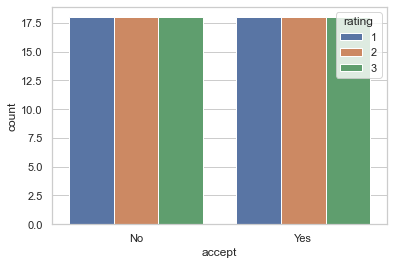

In [215]:
sns.countplot(data=manual_grouped2, x='accept', hue= 'rating');

In [213]:
manual_grouped.head(50)

,reward,m_type,rating,accept
15076,Air Miles,Postcard,3,No
7205,Points,Postcard,2,No
7904,Air Miles,Postcard,2,No
5810,Points,Letter,1,No
8145,Cash Back,Letter,2,No
...,...,...,...,...
12831,Points,Letter,3,Yes
7487,Points,Letter,3,Yes
4761,Cash Back,Letter,2,Yes
1593,Points,Letter,3,Yes


In [219]:
manual_grouped2.head(20)

reward    m_type income accounts  \
reward    m_type   rating accept                                          
Air Miles Letter   1      No     0  Air Miles    Letter      2        1   
                                 1  Air Miles    Letter      3        2   
                                 2  Air Miles    Letter      1        1   
                          Yes    0  Air Miles    Letter      2        1   
                                 1  Air Miles    Letter      2        1   
                                 2  Air Miles    Letter      2        1   
                   2      No     0  Air Miles    Letter      1        1   
                                 1  Air Miles    Letter      2        1   
                                 2  Air Miles    Letter      3        1   
                          Yes    0  Air Miles    Letter      2        1   
                                 1  Air Miles    Letter      3        1   
                                 2  Air Miles    Letter      2        1   
                   3      No     0  Air Miles    Letter      2        2   
                                 1  Air Miles    Letter      3        1   
                                 2  Air Miles    Letter      2        1   
                          Yes    0  Air Miles    Letter      2        1   
                                 1  Air Miles    Letter      2        1   
                                 2  Air Miles    Letter      1        1   
          Postcard 1      No     0  Air Miles  Postcard      2        1   
                                 1  Air Miles  Postcard      1        1   

                                   overdraft rating cards homes family owner  \
reward    m_type   rating accept                                               
Air Miles Letter   1      No     0        No      1     1     2      3    No   
                                 1        No      1     3     2      4    No   
                                 2       Yes      1     2     1      4    No   
                          Yes    0        No      1     1     1      1   Yes   
                                 1        No      1     2     1      2   Yes   
                                 2        No      1     1     2      4   Yes   
                   2      No     0        No      2     1     1      4   Yes   
                                 1        No      2     1     1      2   Yes   
                                 2        No      2     2     1      3   Yes   
                          Yes    0        No      2     2     2      5    No   
                                 1        No      2     1     1      3   Yes   
                                 2        No      2     2     1      2   Yes   
                   3      No     0       Yes      3     2     2      5   Yes   
                                 1        No      3     2     1      3   Yes   
                                 2        No      3     3     1      5    No   
                          Yes    0        No      3     1     1      3   Yes   
                                 1        No      3     2     2      4    No   
                                 2        No      3     2     1      5   Yes   
          Postcard 1      No     0        No      1     2     1      4   Yes   
                                 1       Yes      1     1     1      4   Yes   

                                     balance accept  
reward    m_type   rating accept                     
Air Miles Letter   1      No     0  0.279886     No  
                                 1  0.852218     No  
                                 2  0.798394     No  
                          Yes    0  0.116619    Yes  
                                 1  2.377241    Yes  
                                 2  1.564493    Yes  
                   2      No     0  0.703304     No  
                                 1  0.292445     No  
                                 2  1.175164     No  
                          Yes    

In [201]:
manual_grouped.shape

(108, 4)

In [217]:
manual_grouped2.shape

(108, 12)

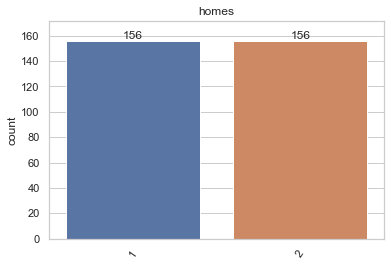

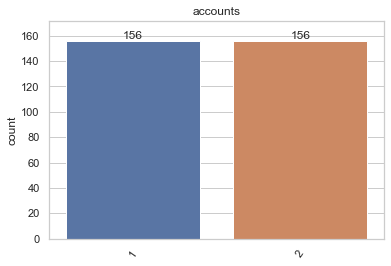

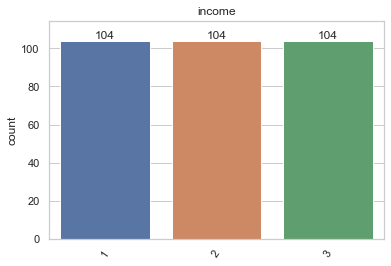

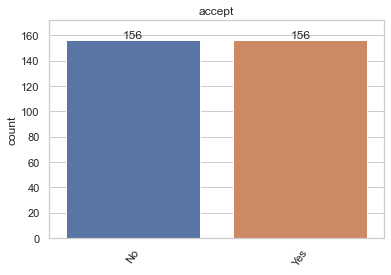

In [154]:
plotDiscrete(df_balanced)

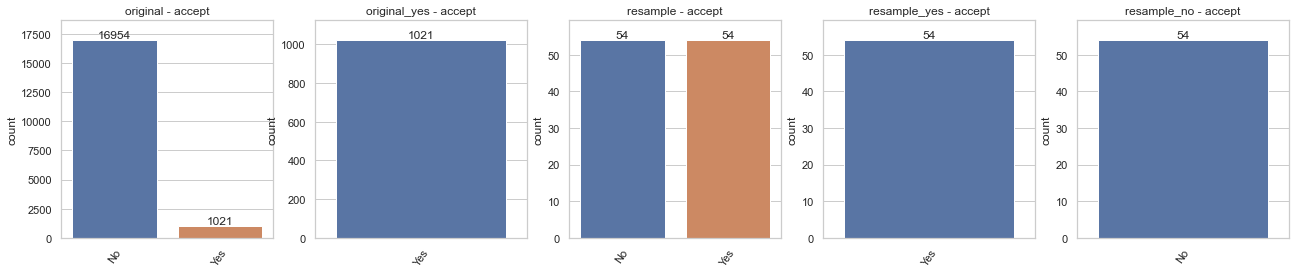

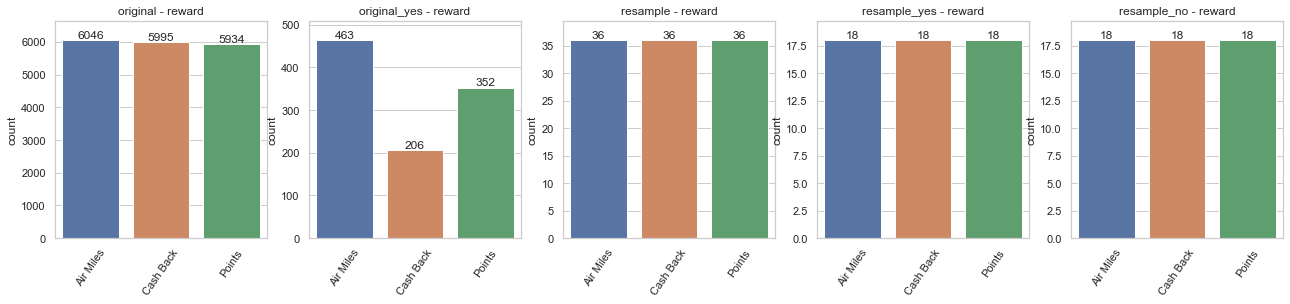

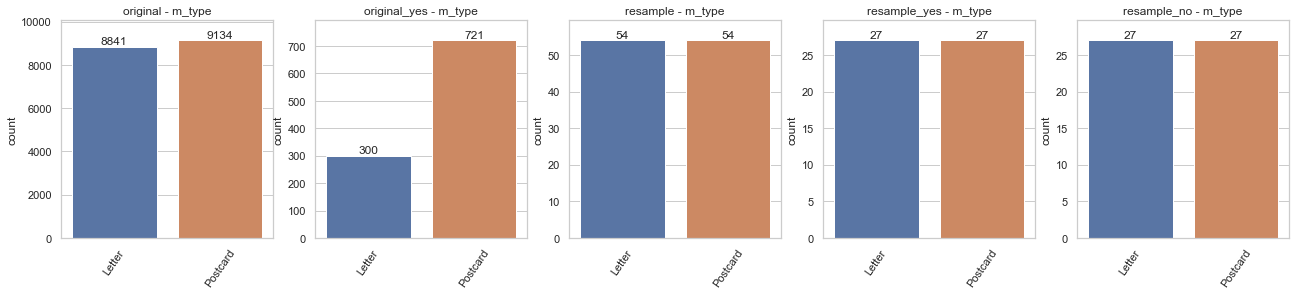

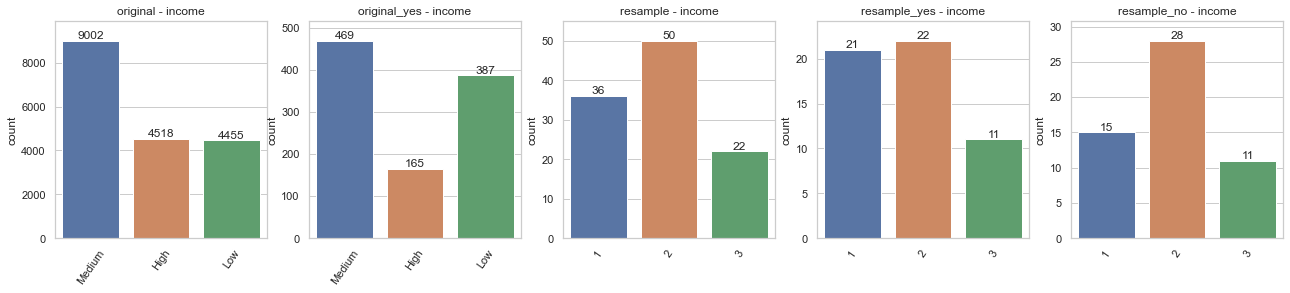

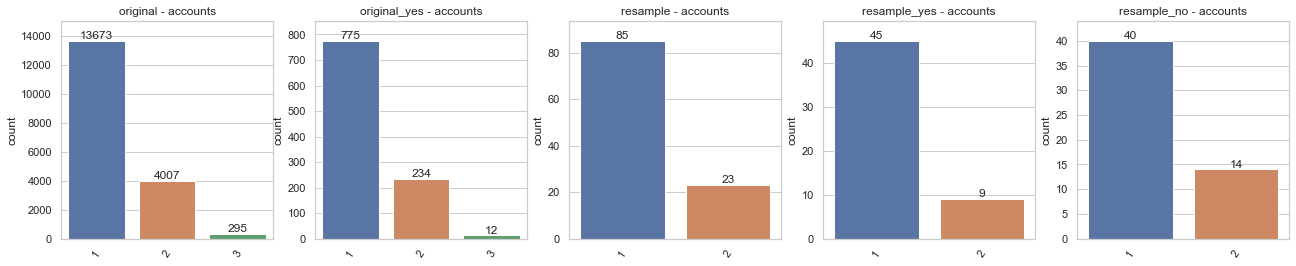

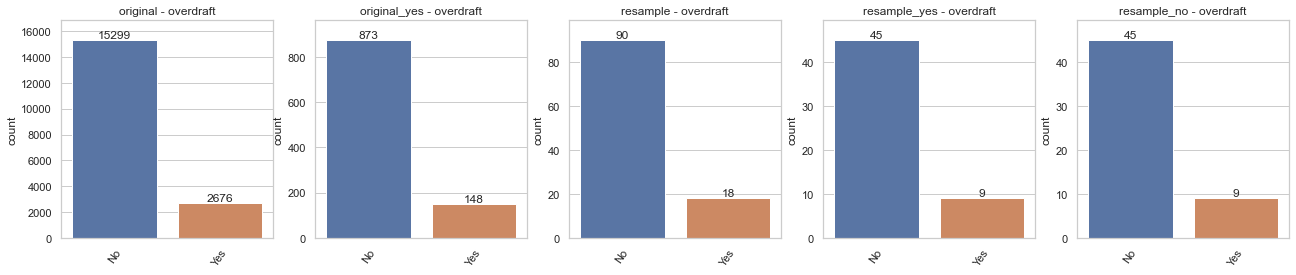

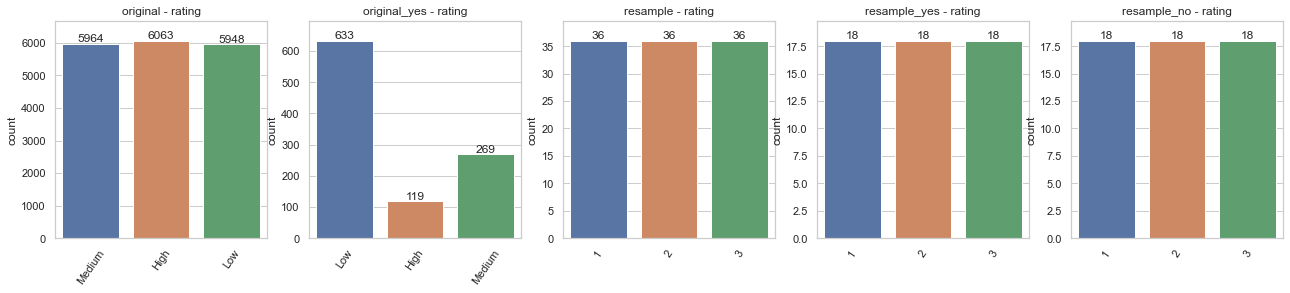

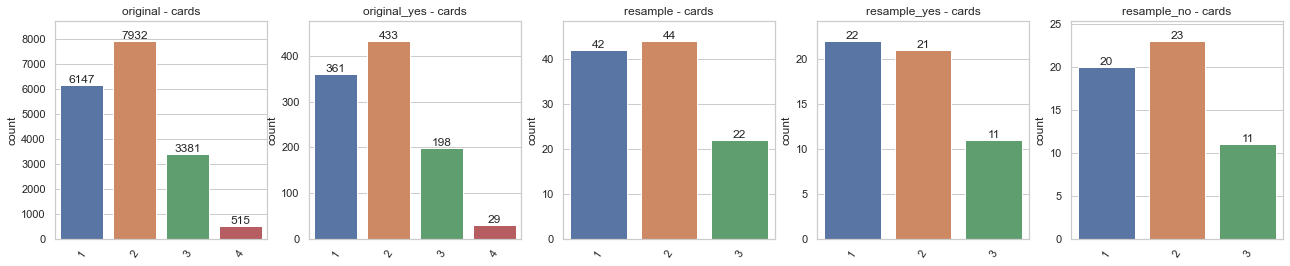

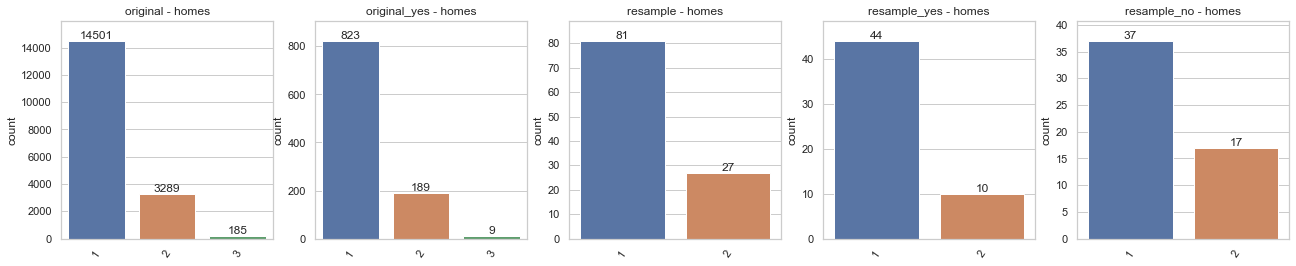

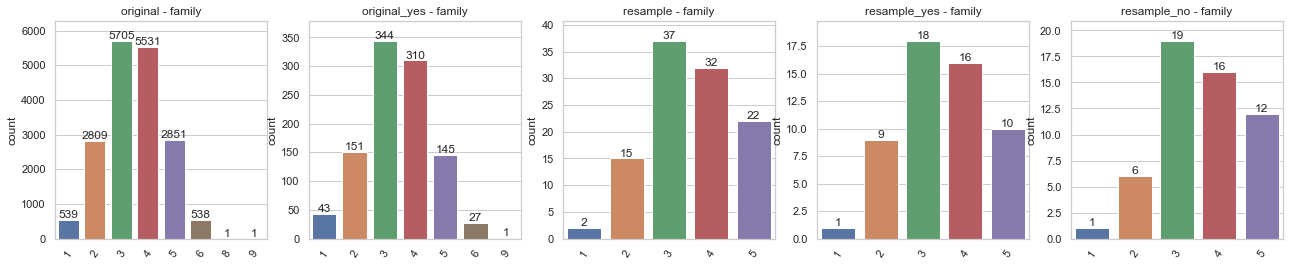

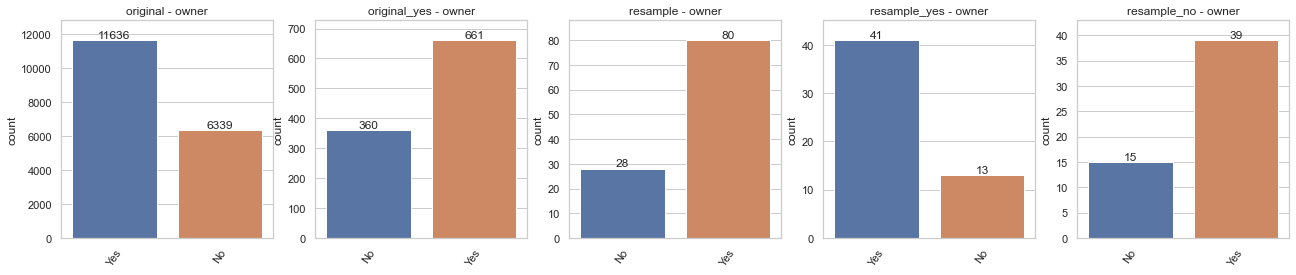

In [218]:
plotCompareResample(disc, manual_grouped2, 'accept', pos_label = 'Yes')

In [ ]:
# Split X-y train manual resampled balanced

In [230]:
X_train_mbal = manual_grouped2.iloc[:,:-1].reset_index(drop=True)

In [231]:
X_train_mbal.shape

(108, 11)

In [232]:
y_train_mbal = manual_grouped2.iloc[:,[-1]].reset_index(drop=True)

In [233]:
y_train_mbal.shape

(108, 1)

## finish preprocessing

In [234]:
X_train_mbal_p, X_test_mbal_p, y_train_mbal_p, y_test_mbal_p = preprocess(X_train_mbal, X_test, y_train_mbal, y_test)

## Manual Balanced Evaluate Logistic Regression

/Users/albertomengual/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/albertomengual/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


The accuracy in the TRAIN set is: 56.5
The precision in the TRAIN set is: 54.55
The recall in the TRAIN set is: 44.44
The F1 in the TRAIN set is: 48.98
The Kappa in the TRAIN set is: 7.41

The accuracy in the TEST set is: 41.10
The precision in the TEST set is: 5.79
The recall in the TEST set is: 58.65
The F1 in the TEST set is: 10.54
The Kappa in the TEST set is: -0.26


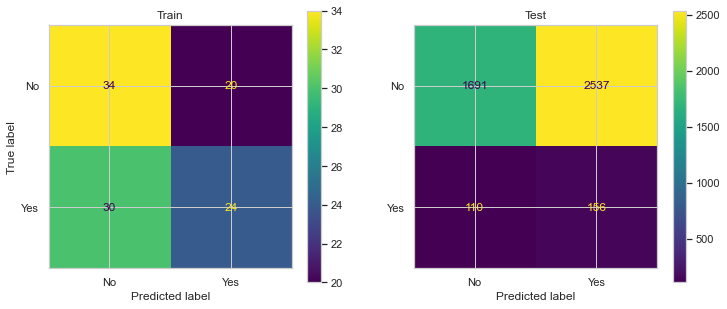

In [236]:
lr_mabl = evaluateLogistic(X_train_mbal_p, X_test_mbal_p, y_train_mbal_p, y_test_mbal_p)

# AllKnn undersampling

# Funtions' summary

In [ ]:
def independencyTest(df,target,alpha=0.05):
    """Checks if the nominal categorical variables are related or not to the target (dependent) variable.
    Inputs:
        df - nominal variables dataframe (the target is the first column)
        target - dependent variable
    Outputs:
        chi2_data - dataframe with the results of the chi2 test
        related_categories - a list of the categories related to the target"""
    
    chi2_data = {'nominal':[],'test_result':[], 'significance':[], 'chi2_st':[]}
    related_categories = []

    for c in df.iloc[:,1:].columns:
        p_value = chi2_contingency(pd.crosstab(df[target], df[c]))[1]
        chi2 = chi2_contingency(pd.crosstab(df[target], df[c]))[0]

        chi2_data['nominal'].append(c)
        chi2_data['significance'].append(p_value)
        chi2_data['chi2_st'].append(chi2)

        if p_value <= 0.05:        
            chi2_data['test_result'].append('Reject Null Hypothesis')

        else:
            chi2_data['test_result'].append('Fail to Reject Null Hypothesis')
            related_categories.append(c)

    chi2_data = pd.DataFrame(chi2_data)
    
    return related_categories, chi2_data
    

In [ ]:
def plotCompareDiscrete(disc, sub_disc):
    """Compare the distributions of classes of two dataframes with the same discrete variables"""
    
    for i,c in enumerate(disc.columns):
        f, ax = plt.subplots(1,2, figsize=(12,5))
        sns.countplot(x=c,data=disc, ax=ax[0])
        sns.countplot(x=c,data=sub_disc,ax=ax[1])


        ax[0].set_title('original_%s' %(c))
        ax[0].set_xlabel(None)
        ax[0].tick_params(axis='x', labelrotation=55)

        ax[1].set_title('compared_%s' %(c))
        ax[1].set_xlabel(None)
        ax[1].tick_params(axis='x', labelrotation=55)

            # annotate
        ax[0].bar_label(ax[0].containers[0], label_type='edge')
        ax[1].bar_label(ax[1].containers[0], label_type='edge')

            # pad the spacing between the number and the edge of the figure
        ax[0].margins(y=0.1)
        ax[1].margins(y=0.1)


        plt.show()


In [ ]:
def evaluateLogistic(X_train, X_test, y_train, y_test, pos_label = 'Yes'):
    """Creates a Logistic Regression and evaluates it
    Inputs:
        preprocessed data
        positive label for the metrics
    returns:
        lr - fitted logistic regression"""
    
    # Create the model and predition
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    y_pred_train = lr_rus.predict(X_train)
    y_pred_test = lr.predict(X_test)
    
    # Compute train score
    train_score = lr.score(X_train,y_train)
    
    # Print the Train Metrics
    print("The accuracy in the TRAIN set is: {:.1f}".format(100*train_score))
    print("The precision in the TRAIN set is: {:.2f}".format(100*precision_score(y_train,y_pred_train, pos_label = pos_label)))
    print("The recall in the TRAIN set is: {:.2f}".format(100*recall_score(y_train,y_pred_train, pos_label = pos_label)))
    print("The F1 in the TRAIN set is: {:.2f}".format(100*f1_score(y_train,y_pred_train, pos_label = pos_label)))
    print("The Kappa in the TRAIN set is: {:.2f}".format(100*cohen_kappa_score(y_train,y_pred_train)))
    
    # Print the Test Metrics
    print()
    print("The accuracy in the TEST set is: {:.2f}".format(100*accuracy_score(y_test,y_pred_test)))
    print("The precision in the TEST set is: {:.2f}".format(100*precision_score(y_test,y_pred_test, pos_label = pos_label)))
    print("The recall in the TEST set is: {:.2f}".format(100*recall_score(y_test,y_pred_test, pos_label = pos_label)))
    print("The F1 in the TEST set is: {:.2f}".format(100*f1_score(y_test,y_pred_test, pos_label = pos_label)))
    print("The Kappa in the TEST set is: {:.2f}".format(100*cohen_kappa_score(y_test,y_pred_test)))
    
    # Display the two confussion matrices
    f, ax = plt.subplots(1,2, figsize=(12,5))
    cm_train = confusion_matrix(y_train,y_pred_train)
    cm_test = confusion_matrix(y_test,y_pred_test)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=lr.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=lr.classes_)
    disp_train.plot(ax = ax[0])
    disp_train.ax_.set_title('Train')
    disp.plot(ax = ax[1])
    disp.ax_.set_title('Test')
    plt.show()

    
    return lr
    
    

In [ ]:
def plotCompareResample(disc, resample, target, pos_label = 'Yes'):
    """Plot a comparision among the original categorical variables with the resampled
    dataframe and the subsets of the resample with positve and non positive label"""

    disc_pos = disc[disc[target] == pos_label]
    
    resample_pos = resample[resample[target] == pos_label]
    resample_neg = resample[resample[target] != pos_label]


    for i,c in enumerate(disc.columns):
            f, ax = plt.subplots(1,5, figsize=(22,4))

            sns.countplot(x=c,data=disc, ax=ax[0])
            sns.countplot(x=c,data=disc_pos, ax=ax[1])
            sns.countplot(x=c,data=resample,ax=ax[2])
            sns.countplot(x=c,data=resample_pos,ax=ax[3])
            sns.countplot(x=c,data=resample_neg,ax=ax[4])


            ax[0].set_title('original - %s' %(c))
            ax[0].set_xlabel(None)
            ax[0].tick_params(axis='x', labelrotation=55)
            
            ax[1].set_title('original_yes - %s' %(c))
            ax[1].set_xlabel(None)
            ax[1].tick_params(axis='x', labelrotation=55)

            ax[2].set_title('resample - %s' %(c))
            ax[2].set_xlabel(None)
            ax[2].tick_params(axis='x', labelrotation=55)

            ax[3].set_title('resample_yes - %s' %(c))
            ax[3].set_xlabel(None)
            ax[3].tick_params(axis='x', labelrotation=55)

            ax[4].set_title('resample_no - %s' %(c))
            ax[4].set_xlabel(None)
            ax[4].tick_params(axis='x', labelrotation=55)

                # annotate
            ax[0].bar_label(ax[0].containers[0], label_type='edge')
            ax[1].bar_label(ax[1].containers[0], label_type='edge')
            ax[2].bar_label(ax[2].containers[0], label_type='edge')
            ax[3].bar_label(ax[3].containers[0], label_type='edge')
            ax[4].bar_label(ax[4].containers[0], label_type='edge')

                # pad the spacing between the number and the edge of the figure
            ax[0].margins(y=0.1)
            ax[1].margins(y=0.1)
            ax[2].margins(y=0.1)
            ax[3].margins(y=0.1)
            ax[4].margins(y=0.1)


            plt.show()

    return None